In [318]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib
from matplotlib import gridspec
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics

import re
import requests
import pandas as pd
import numpy as np
from time import sleep
from bs4 import BeautifulSoup

# TensorFlow and tf.keras
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks

#Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, mpld3
%matplotlib inline
import json
import datetime

from shapely.geometry import Polygon, mapping
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import branca.colormap as cm

### 1. Data Cleaning and EDA

In [319]:
#Load Data
president_results = pd.read_csv('/Users/phili/1976-2016-president.csv')
polls_2020 = pd.read_csv('/Users/phili/president_polls_2020.csv')
polls_1967_2016 = pd.read_csv('/Users/phili/pres_pollaverages_1968-2016.csv')
turnout_2016 = pd.read_csv('/Users/phili/turnout_2016.csv')
turnout_2020 = pd.read_csv('/Users/phili/2020_turnout.csv')
turnout_2020 = turnout_2020[turnout_2020['State'] != 'United States']
results_2020 = pd.read_csv('/Users/phili/2020-CS109A/nyt-2020-election-scraper/all-state-changes.csv')
turnout_1980_2014 = pd.read_csv('/Users/phili/turnout_1980-2014.csv')

In [320]:
#Create list of states
small_states = set(president_results.state)
small_states = sorted(small_states)
state_abv = turnout_2016['State Abv']

**What are the most common pollsters?**

In [321]:
polls_2020['pollster'].value_counts().head(10)

SurveyMonkey                      4646
Morning Consult                   1016
Ipsos                              543
Emerson College                    475
Harris Insights & Analytics        428
YouGov                             422
USC Dornsife/Los Angeles Times     406
SurveyUSA                          365
Public Policy Polling              301
Redfield & Wilton Strategies       288
Name: pollster, dtype: int64

Clearly these polls, which are taken raw from the five-thirty-eight database, use different techniques (I know that surveymonkey is an online survey company, for example). It may be useful to look at the distribution of polling for different states in order to determine which are key battleground states and how much variation there is in the polling.

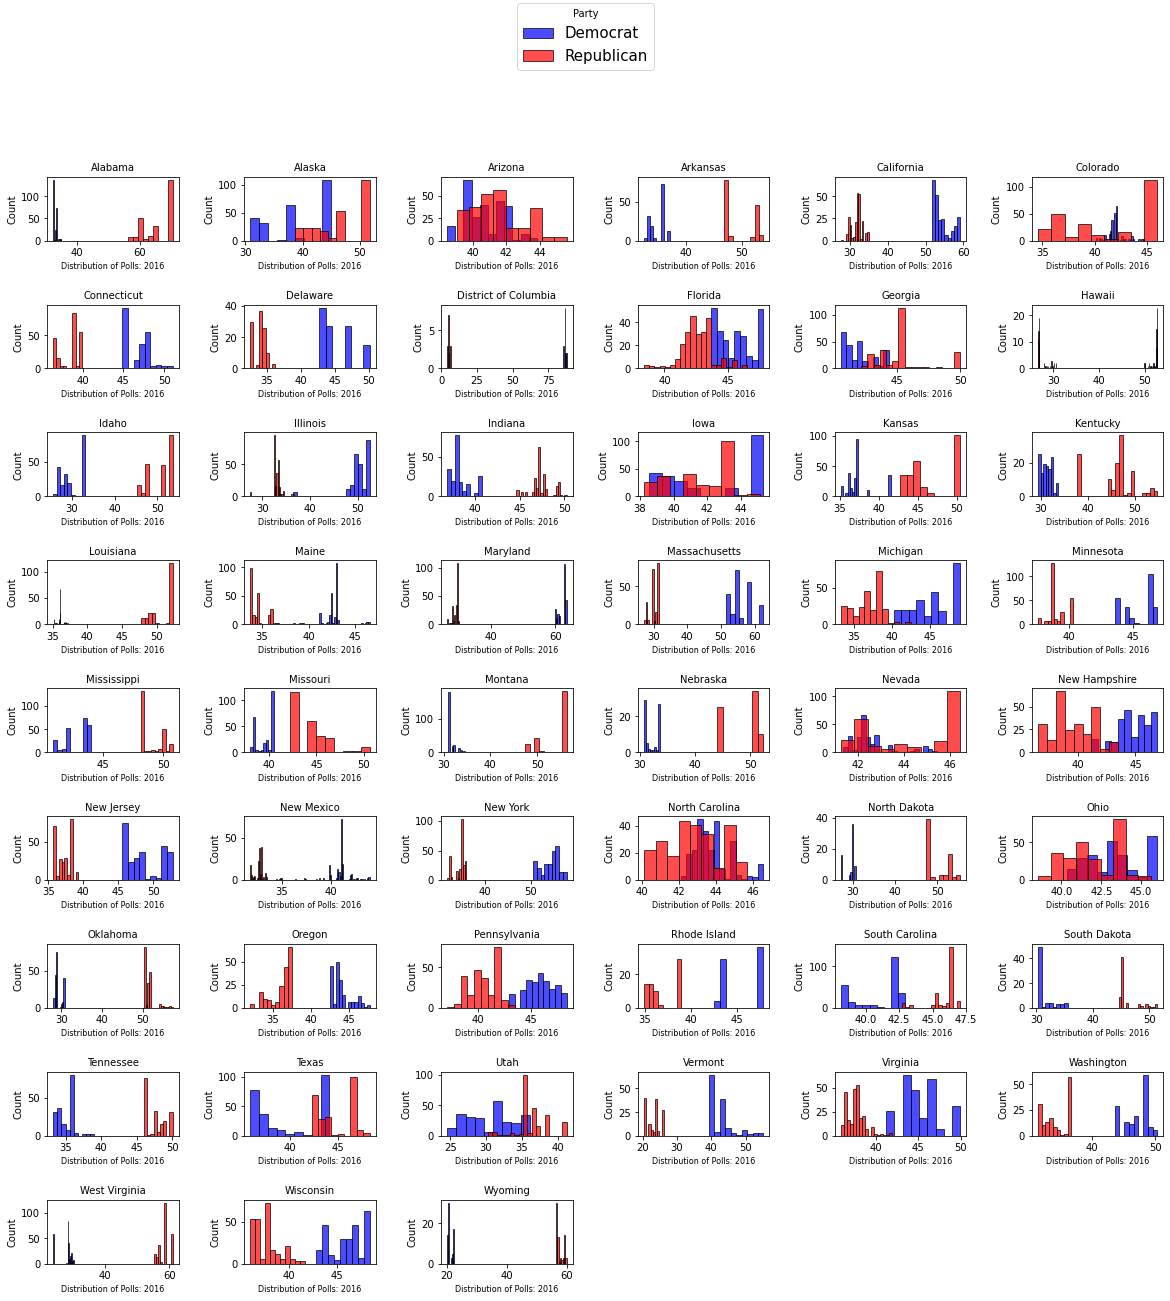

In [322]:
#Exploration of 2016 Polling distributions
fig, axs = plt.subplots(nrows=9, ncols=6, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.5)
axs = axs.ravel()
fontsize = 10

plot_labels = ["Democrat", "Republican"]

# plot histograms
for i, state in enumerate(small_states):
    axs[i].hist(polls_1967_2016[(polls_1967_2016.state == state)  & (polls_1967_2016.cycle ==2016) & (polls_1967_2016.candidate_name == 'Hillary Rodham Clinton')].pct_estimate.values, alpha=0.7, color='blue', bins='auto', density=False, histtype = 'bar', edgecolor='k', label = 'Dem')
    axs[i].hist(polls_1967_2016[(polls_1967_2016.state == state)  & (polls_1967_2016.cycle ==2016) & (polls_1967_2016.candidate_name == 'Donald Trump')].pct_estimate.values, alpha=0.7, color='red', bins='auto', density=False, histtype = 'bar', edgecolor='k', label = 'Rep')
    axs[i].set_title(state, fontsize=fontsize)
    axs[i].set_xlabel("Distribution of Polls: 2016", fontsize=8)
    axs[i].set_ylabel('Count', fontsize=fontsize)


axs[53].set_axis_off()
axs[52].set_axis_off()
axs[51].set_axis_off()

fig.legend(    # The line objects
           labels=plot_labels,   
           loc="upper center",   
           borderaxespad=0.2,    
           title="Party",
           fontsize=15
           )

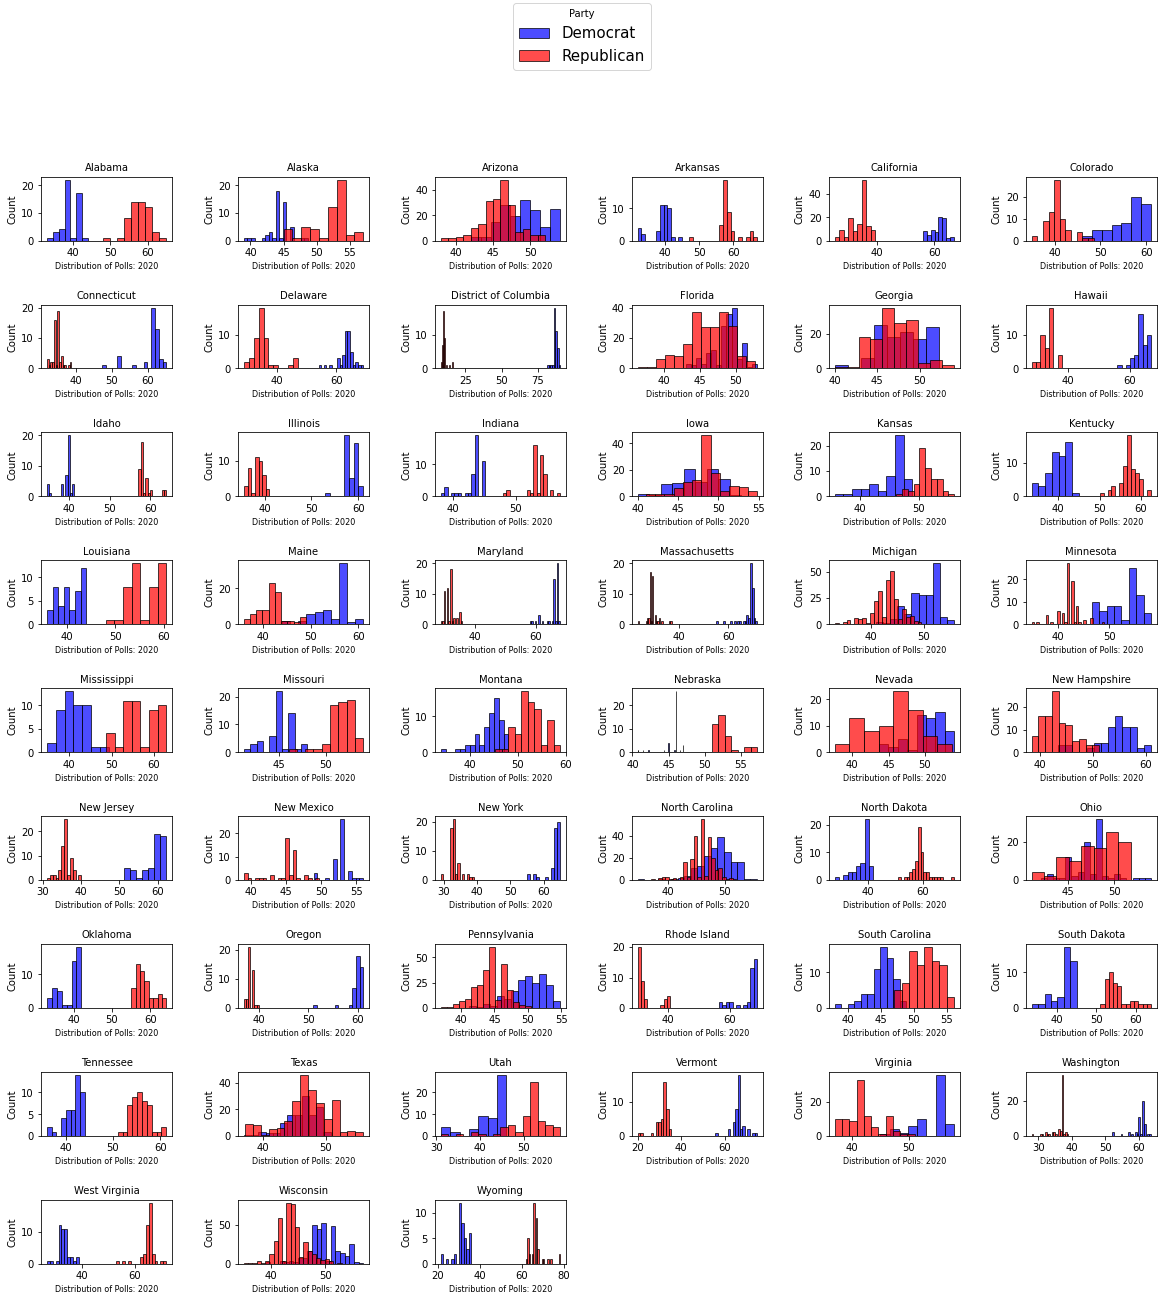

In [323]:
#Exploration of 2020 Polling distributions
fig, axs = plt.subplots(nrows=9, ncols=6, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 1, wspace=.5)
axs = axs.ravel()
fontsize = 10

plot_labels = ["Democrat", "Republican"]

# plot histograms
for i, state in enumerate(small_states):
    axs[i].hist(polls_2020[(polls_2020.state == state) & (polls_2020.candidate_name == 'Joseph R. Biden Jr.')].pct.values, alpha=0.7, color='blue', bins='auto', density=False, histtype = 'bar', edgecolor='k', label='Dem')
    axs[i].hist(polls_2020[(polls_2020.state == state) & (polls_2020.candidate_name == 'Donald Trump')].pct.values, alpha=0.7, color='red', bins='auto', density=False, histtype = 'bar', edgecolor='k', label='Rep')
    axs[i].set_title(state, fontsize=fontsize)
    axs[i].set_xlabel("Distribution of Polls: 2020", fontsize=8)
    axs[i].set_ylabel('Count', fontsize=fontsize)


axs[53].set_axis_off()
axs[52].set_axis_off()
axs[51].set_axis_off()

fig.legend(    # The line objects
           labels=plot_labels,   
           loc="upper center",   
           borderaxespad=0.2,    
           title="Party",
           fontsize=15
           )

From both 2020 and 2016 polls we can see that some states are more likely to be polled than others. For example, Arizona and Florida were polled more in 2020 than other states, compared to states such as West Virginia and Wyoming. It seems that states where Democrats and Republicans are closer have more polls taken. This makes sense because there is likely to be a greater premium on predicting these swing states. This should be taken into consideration in further analysis in order to weight polls accurately. However, in order to gain a baseline model polls will be averaged for each year and each state.

In [324]:
#Clean and extract polls since 1980
full_polls_dem = []
cycles = sorted(set(polls_1967_2016.cycle))
cycles = cycles[3:]
dem_candidates = ['Jimmy Carter', 'Walter F. Mondale', 'Michael S. Dukakis', 'Bill Clinton', 'Bill Clinton', 'Al Gore', 'John Kerry', 'Barack Obama', 'Barack Obama', 'Hillary Rodham Clinton']
for i, cycle in enumerate(cycles):
    for state in small_states:
        full_polls_dem.append(np.mean(polls_1967_2016[(polls_1967_2016.state == state)  & (polls_1967_2016.cycle ==cycle) & (polls_1967_2016.candidate_name == dem_candidates[i])].pct_estimate.values))


C:\Users\phili\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\phili\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [325]:
full_polls_rep = []
cycles = sorted(set(polls_1967_2016.cycle))
cycles = cycles[3:]
rep_candidates = ['Ronald Reagan', 'Ronald Reagan', 'George Bush', 'George Bush', 'Bob Dole', 'George W. Bush', 'George W. Bush', 'John McCain', 'Mitt Romney', 'Donald Trump']
for i, cycle in enumerate(cycles):
    for state in small_states:
        full_polls_rep.append(np.mean(polls_1967_2016[(polls_1967_2016.state == state)  & (polls_1967_2016.cycle ==cycle) & (polls_1967_2016.candidate_name == rep_candidates[i])].pct_estimate.values))


In [326]:
#Clean and extract results since 1980
full_results_list = []
full_results_dem = []
full_results_rep = []
for i, cycle in enumerate(cycles):
    for j, state in enumerate(small_states):
        full_results_dem.append(np.mean(president_results[(president_results.state == state)  & (president_results.year ==cycle) & (president_results.party == 'democrat')].candidatevotes.values))
        full_results_rep.append(np.mean(president_results[(president_results.state == state)  & (president_results.year ==cycle) & (president_results.party == 'republican')].candidatevotes.values))
        if full_results_dem[j] > full_results_rep[j]:
            full_results_list.append(1)
        else:
            full_results_list.append(0)


In [327]:
#Extracting turnout from 'United States Election Project' Data

all_turnout = []
all_vep = []
all_prison = []
all_non_citizen = []
cycles_to_2014 = cycles[:-1]
for i, cycle in enumerate(cycles_to_2014):
    for j, state in enumerate(small_states):
        all_turnout.append(turnout_1980_2014[(turnout_1980_2014.state == state) & (turnout_1980_2014.Year ==cycle)]['VEP Highest Office'].values[0]) 
        all_vep.append(turnout_1980_2014[(turnout_1980_2014.state == state) & (turnout_1980_2014.Year ==cycle)]['Voting-Eligible Population (VEP)'].values[0])
        all_prison.append(turnout_1980_2014[(turnout_1980_2014.state == state) & (turnout_1980_2014.Year ==cycle)]['Prison'].values[0])
        all_non_citizen.append(turnout_1980_2014[(turnout_1980_2014.state == state) & (turnout_1980_2014.Year ==cycle)]['% Non-citizen'].values[0])

all_turnout_2016 = []
vep_2016 = []
prison_2016 = []
non_citizen_2016 = []
for state in small_states:
    all_turnout_2016.append(turnout_2016[(turnout_2016.state == state)]['VEP Highest Office'].values[0]) 
    vep_2016.append(turnout_2016[(turnout_2016.state == state)]['Voting-Eligible Population (VEP)'].values[0])
    prison_2016.append(turnout_2016[(turnout_2016.state == state)]['Prison'].values[0])
    non_citizen_2016.append(turnout_2016[(turnout_2016.state == state)]['% Non-citizen'].values[0])

full_turnout = all_turnout + all_turnout_2016
full_vep = all_vep + vep_2016
full_prison = all_prison + prison_2016
full_non_citizen = all_non_citizen + non_citizen_2016

In [328]:
prev_cycles = sorted(set(polls_1967_2016.cycle))
prev_cycles = prev_cycles[2:-1]

In [329]:
#Clean and extract previous polls since 1980
prev_polls_dem = []
dem_candidates = ['Jimmy Carter', 'Jimmy Carter', 'Walter F. Mondale', 'Michael S. Dukakis', 'Bill Clinton', 'Bill Clinton', 'Al Gore', 'John Kerry', 'Barack Obama', 'Barack Obama']
for i, cycle in enumerate(prev_cycles):
    for state in small_states:
        prev_polls_dem.append(np.mean(polls_1967_2016[(polls_1967_2016.state == state)  & (polls_1967_2016.cycle ==cycle) & (polls_1967_2016.candidate_name == dem_candidates[i])].pct_estimate.values))


In [330]:
prev_polls_rep = []
rep_candidates = ['Gerald Ford', 'Ronald Reagan', 'Ronald Reagan', 'George Bush', 'George Bush', 'Bob Dole', 'George W. Bush', 'George W. Bush', 'John McCain', 'Mitt Romney']
for i, cycle in enumerate(prev_cycles):
    for state in small_states:
        prev_polls_rep.append(np.mean(polls_1967_2016[(polls_1967_2016.state == state)  & (polls_1967_2016.cycle ==cycle) & (polls_1967_2016.candidate_name == rep_candidates[i])].pct_estimate.values))


In [331]:
#Clean and extract previous Democrat polls for 2016 to add to test set as previous polls
polls_dem_2016 = []
dem_candidates = ['Hillary Rodham Clinton']
for state in small_states:
    polls_dem_2016.append(np.mean(polls_1967_2016[(polls_1967_2016.state == state)  & (polls_1967_2016.cycle ==2016) & (polls_1967_2016.candidate_name == 'Hillary Rodham Clinton')].pct_estimate.values))


In [332]:
#Clean and extract previous Republican polls for 2016 to add to test set as previous polls
polls_rep_2016 = []
for state in small_states:
    polls_dem_2016.append(np.mean(polls_1967_2016[(polls_1967_2016.state == state)  & (polls_1967_2016.cycle ==2016) & (polls_1967_2016.candidate_name == 'Donald Trump')].pct_estimate.values))


In [333]:
#Clean and extract previous results since 1980
prev_results_list = []
prev_results_dem = []
prev_results_rep = []
for i, cycle in enumerate(prev_cycles):
    for j, state in enumerate(small_states):
        prev_results_dem.append(np.mean(president_results[(president_results.state == state)  & (president_results.year ==cycle) & (president_results.party == 'democrat')].candidatevotes.values))
        prev_results_rep.append(np.mean(president_results[(president_results.state == state)  & (president_results.year ==cycle) & (president_results.party == 'republican')].candidatevotes.values))
        if prev_results_dem[j] > prev_results_rep[j]:
            prev_results_list.append(1)
        else:
            prev_results_list.append(0)


In [334]:
#Populating dataframe with year and state details
years = []
for i, cycle in enumerate(cycles):
    for j in range(len(small_states)):
        years.append(cycle)
states_10 = small_states * 10
state_abv = state_abv[0:51]
state_abv_10 = state_abv * 10

In [335]:
#Load train data into dataframe
train = {'year': years, 'state': states_10 , 'dem_votes': full_results_dem, 'rep_votes': full_results_rep, 'rep_polls': full_polls_rep, 'dem_polls': full_polls_dem,  
    'turnout': full_turnout, 'vep': full_vep, 'prison': full_prison, 'non-citizen': full_non_citizen, 'outcome': full_results_list, 'prev_outcome': prev_results_list, 
        'prev_outcome_margin': full_results_list, 'prev_dem_results':prev_results_dem, 'prev_rep_results':prev_results_rep, 'prev_polls_rep': prev_polls_rep, 'prev_polls_dem': prev_polls_dem, 'prev_polls_outcome': full_results_list, 'prev_polls_margin':full_results_list, 'polls_strike_rate':full_results_list} 
train_data = pd.DataFrame(data=train)

Seperate models will be used to impute the missing data in each column. After analysing the resulting coefficients from simply imputing the mean, and also simply dropping the rows, it was clear that using a regression model to impute missing values was preferable.

In [336]:
df_mcar = train_data.copy()

# fit the imputation model
ols_imputer = LinearRegression().fit(df_mcar.dropna()[['prev_rep_results']],df_mcar.dropna()['prev_polls_dem'])

# perform some imputations
prev_polls_dem_hat_impute = pd.Series(ols_imputer.predict(df_mcar[['prev_rep_results']]))
df_mcar['prev_polls_dem'] = df_mcar['prev_polls_dem'].fillna(prev_polls_dem_hat_impute)

# fit the model we care about
ols_mcar_ols = LinearRegression().fit(df_mcar[['prev_polls_dem','prev_rep_results']],df_mcar['outcome'])
print(ols_mcar_ols.intercept_,ols_mcar_ols.coef_)

-0.3038060295189323 [ 1.22058634e-02 -4.03425677e-08]


In [337]:
#Compare to just dropping rows
ols_drop = LinearRegression().fit(df_mcar.dropna()[['prev_polls_dem','prev_rep_results']],df_mcar.dropna()['outcome'])
print(ols_drop.intercept_,ols_drop.coef_)

-0.2645562144964487 [ 1.09557338e-02 -3.64960190e-08]


Based on analysing the coefficients of the resulting model, this is a better approach compared to imputing the mean or simply dropping rows. Therefore we will use an ols imputer to impute the other missing values.

In [338]:
#Impute Previous Republican Polls Missing values
ols_imputer = LinearRegression().fit(df_mcar.dropna()[['prev_rep_results']],df_mcar.dropna()['prev_polls_rep'])

prev_polls_dem_hat_impute = pd.Series(ols_imputer.predict(df_mcar[['prev_rep_results']]))
df_mcar['prev_polls_rep'] = df_mcar['prev_polls_rep'].fillna(prev_polls_dem_hat_impute)

In [339]:
#Impute Republican Polls Missing Values
ols_imputer = LinearRegression().fit(df_mcar.dropna()[['prev_rep_results']],df_mcar.dropna()['rep_polls'])

prev_polls_dem_hat_impute = pd.Series(ols_imputer.predict(df_mcar[['prev_rep_results']]))
df_mcar['rep_polls'] = df_mcar['rep_polls'].fillna(prev_polls_dem_hat_impute)

In [340]:
#Impute values for dem polls
ols_imputer = LinearRegression().fit(df_mcar.dropna()[['prev_rep_results']],df_mcar.dropna()['dem_polls'])

prev_polls_dem_hat_impute = pd.Series(ols_imputer.predict(df_mcar[['prev_rep_results']]))
df_mcar['dem_polls'] = df_mcar['dem_polls'].fillna(prev_polls_dem_hat_impute)

In [341]:
#Impute values for previous democrat results
ols_imputer = LinearRegression().fit(df_mcar.dropna()[['prev_rep_results']],df_mcar.dropna()['prev_dem_results'])

prev_polls_dem_hat_impute = pd.Series(ols_imputer.predict(df_mcar[['prev_rep_results']]))
df_mcar['prev_dem_results'] = df_mcar['prev_dem_results'].fillna(prev_polls_dem_hat_impute)

However, 'Dem Votes' has Na, and imputing the number of votes is not ideal as this is a critical variable. Therefore we check to see where the NAs are.

In [342]:

train_data['dem_votes'].isnull()

0      False
1      False
2      False
3      False
4      False
       ...  
505    False
506    False
507    False
508    False
509    False
Name: dem_votes, Length: 510, dtype: bool

In [343]:
is_NaN = train_data.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = train_data[row_has_NaN]
print(rows_with_NaN)

     year        state  dem_votes  rep_votes  rep_polls  dem_polls turnout  \
0    1980      Alabama   636730.0   654192.0  40.601435  43.208668  49.20%   
1    1980       Alaska    41842.0    86112.0        NaN        NaN  58.70%   
2    1980      Arizona   246843.0   529688.0  45.203876  21.825982  46.20%   
3    1980     Arkansas   398041.0   403164.0  41.219636  41.828129  52.00%   
4    1980   California  3082943.0  4522994.0  42.603761  26.681597  55.00%   
..    ...          ...        ...        ...        ...        ...     ...   
460  2016       Alaska   116454.0   163387.0  46.835547  39.127921  61.00%   
466  2016     Delaware   235603.0   185127.0  33.946893  45.101711  64.20%   
482  2016    Minnesota  1367705.0  1322949.0  39.010988  45.478964  74.10%   
483  2016  Mississippi   485131.0   700714.0  48.978002  42.942970  55.20%   
509  2016      Wyoming    55973.0   174419.0  57.573262  21.081943  59.50%   

            vep  prison non-citizen  outcome  prev_outcome  \
0

The NAs are in Minnesota in 2000, 2004 and 2012. It is most efficient to just input these mannually. It is not clear why this data was not in the MIT Elections database. These manually inserted results are taken from Wikipedia.

In [344]:
train_data['dem_votes'][278] = 1168266
train_data['dem_votes'][329] = 1445014
train_data['dem_votes'][431] = 1546167

<ipython-input-344-21404ed8d86d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['dem_votes'][278] = 1168266
<ipython-input-344-21404ed8d86d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['dem_votes'][329] = 1445014
<ipython-input-344-21404ed8d86d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['dem_votes'][431] = 1546167


In [345]:
#Add the imputed values to the original dataset
train_data['dem_polls'] = df_mcar['dem_polls']
train_data['rep_polls'] = df_mcar['rep_polls']
train_data['prev_polls_rep'] = df_mcar['prev_polls_rep']
train_data['prev_polls_dem'] = df_mcar['prev_polls_dem']
train_data['prev_dem_results'] = df_mcar['prev_dem_results']

In [346]:
train_data['results'] = train_data['dem_votes'] - train_data['rep_votes']

In [347]:
for cells in range(len(train_data)):
    if train_data['dem_votes'][cells] > train_data['rep_votes'][cells]:
        train_data['outcome'][cells] = 1
    else: 
        train_data['outcome'][cells] = 0

<ipython-input-347-8625c1ce955b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['outcome'][cells] = 0
<ipython-input-347-8625c1ce955b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['outcome'][cells] = 1


In [348]:
#Engineer new variables, including 'previous outcome margin' and 'previous polls margin'
train_data['prev_outcome_margin'] = train_data['prev_dem_results'] - train_data['prev_rep_results']
train_data['prev_polls_margin'] = train_data['prev_polls_dem'] - train_data['prev_polls_rep']

for cells in range(len(train_data)):
    if train_data['prev_polls_dem'][cells] > train_data['prev_polls_rep'][cells]:
        train_data['prev_polls_outcome'][cells] = 1
    else: 
        train_data['prev_polls_outcome'][cells] = 0

<ipython-input-348-529b084afdf5>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prev_polls_outcome'][cells] = 0
<ipython-input-348-529b084afdf5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prev_polls_outcome'][cells] = 1


In [349]:
#Engineer new variable: Previous outcome
for cells in range(len(train_data)):
    if train_data['prev_dem_results'][cells] > train_data['prev_rep_results'][cells]:
        train_data['prev_outcome'][cells] = 1
    else: 
        train_data['prev_outcome'][cells] = 0

<ipython-input-349-48c5a929044d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prev_outcome'][cells] = 1
<ipython-input-349-48c5a929044d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['prev_outcome'][cells] = 0


In [350]:
#Engineer new variables, polls outcome
train_data['polls_outcome'] = full_results_list

for cells in range(len(train_data)):
    if train_data['dem_polls'][cells] > train_data['rep_polls'][cells]:
        train_data['polls_outcome'][cells] = 1
    else: 
        train_data['polls_outcome'][cells] = 0

<ipython-input-350-38c83c11b6eb>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['polls_outcome'][cells] = 1
<ipython-input-350-38c83c11b6eb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['polls_outcome'][cells] = 0


In [351]:
def get_matches(state, cycle):
    return (np.sum(train_data[(train_data.state == state) & (train_data.year == cycle)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == cycle)].prev_outcome.values))

In [352]:
def get_cycle_strike(cycle_num):
    polls_strike_dict = {}
    mod_cycles = cycles[0:cycle_num]
    for i in cycles:
        polls_strike_dict[cycles[cycle_num]] = {}
        for j, state in enumerate(small_states):
            polls_strike_dict[cycles[cycle_num]][state] = get_matches(state, cycles[cycle_num])
        return polls_strike_dict

In [353]:
def get_strike_list(cycle_num):   
    strike_list = []
    for j, state in enumerate(small_states):
        if cycle_num == 0:
            strike_list.append(get_cycle_strike(0)[cycles[cycle_num]].get(state))
        elif cycle_num == 1:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state))/2)
        elif cycle_num == 2:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state) + get_cycle_strike(2)[cycles[2]].get(state))/3)
        elif cycle_num == 3:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state) + get_cycle_strike(2)[cycles[2]].get(state) + get_cycle_strike(3)[cycles[3]].get(state))/4)
        elif cycle_num == 4:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state) + get_cycle_strike(2)[cycles[2]].get(state) + get_cycle_strike(3)[cycles[3]].get(state) + get_cycle_strike(4)[cycles[4]].get(state))/5)
        elif cycle_num == 5:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state) + get_cycle_strike(2)[cycles[2]].get(state) + get_cycle_strike(3)[cycles[3]].get(state) + get_cycle_strike(4)[cycles[4]].get(state) + get_cycle_strike(5)[cycles[5]].get(state))/6)
        elif cycle_num == 6:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state) + get_cycle_strike(2)[cycles[2]].get(state) + get_cycle_strike(3)[cycles[3]].get(state) + get_cycle_strike(4)[cycles[4]].get(state) + get_cycle_strike(5)[cycles[5]].get(state) + get_cycle_strike(6)[cycles[6]].get(state))/7)
        elif cycle_num == 7:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state) + get_cycle_strike(2)[cycles[2]].get(state) + get_cycle_strike(3)[cycles[3]].get(state) + get_cycle_strike(4)[cycles[4]].get(state) + get_cycle_strike(5)[cycles[5]].get(state) + get_cycle_strike(6)[cycles[6]].get(state) + get_cycle_strike(7)[cycles[7]].get(state))/8)
        elif cycle_num == 8:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state) + get_cycle_strike(2)[cycles[2]].get(state) + get_cycle_strike(3)[cycles[3]].get(state) + get_cycle_strike(4)[cycles[4]].get(state) + get_cycle_strike(5)[cycles[5]].get(state) + get_cycle_strike(6)[cycles[6]].get(state) + get_cycle_strike(7)[cycles[7]].get(state) + get_cycle_strike(8)[cycles[8]].get(state))/9)
        elif cycle_num == 9:
            strike_list.append((get_cycle_strike(0)[cycles[0]].get(state) + get_cycle_strike(1)[cycles[1]].get(state) + get_cycle_strike(2)[cycles[2]].get(state) + get_cycle_strike(3)[cycles[3]].get(state) + get_cycle_strike(4)[cycles[4]].get(state) + get_cycle_strike(5)[cycles[5]].get(state) + get_cycle_strike(6)[cycles[6]].get(state) + get_cycle_strike(7)[cycles[7]].get(state) + get_cycle_strike(8)[cycles[8]].get(state) + get_cycle_strike(9)[cycles[9]].get(state))/10)
    return strike_list

In [354]:
all_polls_strike = get_strike_list(0) + get_strike_list(1) + get_strike_list(2) + get_strike_list(3) + get_strike_list(4) + get_strike_list(5) + get_strike_list(6) + get_strike_list(7) + get_strike_list(8) + get_strike_list(9)

In [355]:
polls_correct_test = []
for j, state in enumerate(small_states):
    polls_correct_test.append((np.sum(train_data[(train_data.state == state) & (train_data.year == 2016)].polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 2016)].outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1988)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 2016)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1988)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 2012)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1988)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 1988)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1988)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 2004)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1988)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 2000)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1988)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 1996)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1988)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 1992)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1988)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 1988)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1980)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 1980)].prev_outcome.values) + np.sum(train_data[(train_data.state == state) & (train_data.year == 1984)].prev_polls_outcome.values == train_data[(train_data.state == state) & (train_data.year == 1984)].prev_outcome.values))/11)

In [356]:
train_data['polls_strike_rate'] = all_polls_strike

In [357]:
train_data['polls_margin'] = train_data['dem_polls'] - train_data['rep_polls']

In [358]:
#Remove percentage signs from variables
train_data['turnout'] = pd.to_numeric(train_data['turnout'].str[:-1])
train_data['non-citizen'] = pd.to_numeric(train_data['non-citizen'].str[:-1])
train_data['prison'] = train_data['prison'].replace(to_replace =',', value = '', regex = True)
train_data['prison'] = pd.to_numeric(train_data['prison']) 
train_data['vep'] = train_data['vep'].replace(to_replace =',', value = '', regex = True) 
train_data['vep'] = pd.to_numeric(train_data['vep'])

In [359]:
#Prepare test dataframe
years_2020 = []
for i in range(len(small_states)):
    years_2020.append(2020)
    
winner_list = []
vote_difference_2020 = []
for state in small_states:
    winner_list.append(results_2020[results_2020['state'].str.contains(state)][0:1].leading_candidate_name.values[0])
    vote_difference_2020.append(results_2020[results_2020['state'].str.contains(state)][0:1].vote_differential.values[0])

Outcome_2020 = []
vote_diff_biden = []
for i, winner in enumerate(winner_list):
    if winner == 'Trump':
        Outcome_2020.append(0)
        vote_diff_biden.append(-vote_difference_2020[i])
    else:
        Outcome_2020.append(1)
        vote_diff_biden.append(vote_difference_2020[i])
        
all_turnout_2020 = []
vep_2020 = []
prison_2020 = []
non_citizen_2020 = []
for state in small_states:
    all_turnout_2020.append(turnout_2020[(turnout_2020.State == state)]['VEP Turnout Rate'].values[0]) 
    vep_2020.append(turnout_2020[(turnout_2020.State == state)]['Voting-Eligible Population (VEP)'].values[0])
    prison_2020.append(turnout_2020[(turnout_2020.State == state)]['Prison'].values[0])
    non_citizen_2020.append(turnout_2020[(turnout_2020.State == state)]['% Non-citizen'].values[0])
    
polls_2020_dem = []
polls_2020_rep = []
for state in small_states:
    polls_2020_dem.append(np.mean(polls_2020[(polls_2020.state == state) & (polls_2020.candidate_name == 'Joseph R. Biden Jr.')].pct.values))
    polls_2020_rep.append(np.mean(polls_2020[(polls_2020.state == state) & (polls_2020.candidate_name == 'Donald Trump')].pct.values))

In [360]:
#Load test data into a dataframe
test = {'year': years_2020, 'state': small_states, 'rep_polls': polls_2020_rep, 'dem_polls': polls_2020_dem, 'results': vote_diff_biden,
    'turnout': all_turnout_2020, 'vep': vep_2020, 'prison': prison_2020, 'non-citizen': non_citizen_2020, 'outcome': Outcome_2020,
        'prev_outcome': years_2020, 'prev_outcome_margin': years_2020, 'prev_dem_results':years_2020, 'prev_rep_results':years_2020, 'prev_polls_rep': years_2020, 'prev_polls_dem': years_2020, 'prev_polls_outcome': years_2020, 'prev_polls_margin':years_2020, 'polls_strike_rate':polls_correct_test}
test_data = pd.DataFrame(data=test)

In [361]:
test_data['prev_outcome'] = train_data[(train_data.year == 2016)].outcome.values

In [362]:
test_data['prev_dem_results'] = train_data[(train_data.year == 2016)].dem_votes.values
test_data['prev_rep_results'] = train_data[(train_data.year == 2016)].rep_votes.values
test_data['prev_polls_rep'] = train_data[(train_data.year == 2016)].rep_polls.values
test_data['prev_polls_dem'] = train_data[(train_data.year == 2016)].dem_polls.values
test_data['prev_outcome_margin'] = train_data[(train_data.year == 2016)].dem_votes.values - train_data[(train_data.year == 2016)].rep_votes.values
test_data['prev_polls_outcome'] = train_data[(train_data.year == 2016)].polls_outcome.values
test_data['prev_polls_margin'] = train_data[(train_data.year == 2016)].dem_polls.values - train_data[(train_data.year == 2016)].rep_polls.values

In [363]:
test_data['turnout'] = pd.to_numeric(test_data['turnout'].str[:-1])
test_data['non-citizen'] = pd.to_numeric(test_data['non-citizen'].str[:-1])
test_data['prison'] = test_data['prison'].replace(to_replace =',', value = '', regex = True) 
test_data['prison'] = pd.to_numeric(test_data['prison'])
test_data['vep'] = test_data['vep'].replace(to_replace =',', value = '', regex = True) 
test_data['vep'] = pd.to_numeric(test_data['vep'])

In [364]:
test_data['polls_margin'] = test_data['dem_polls'] - test_data['rep_polls']
test_data['polls_outcome'] = years_2020

for cells in range(len(test_data)):
    if test_data['dem_polls'][cells] > test_data['rep_polls'][cells]:
        test_data['polls_outcome'][cells] = 1
    else: 
        test_data['polls_outcome'][cells] = 0

<ipython-input-364-654fd572ab62>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['polls_outcome'][cells] = 0
<ipython-input-364-654fd572ab62>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['polls_outcome'][cells] = 1


In [365]:
#Drop unneccessary variables from both dataframes related to outcome.
train_data = train_data.drop('rep_votes', axis=1)
train_data = train_data.drop('dem_votes', axis=1)
train_data = train_data.drop('results', axis=1)
test_data = test_data.drop('results',axis=1)

In [366]:
#We should see how certain we are about polls in the 2020 election. We can plot the certainty of the polls for the 2020 election.
#Create CSV for sharing
#train_data.to_csv('president_train_data_final_2.csv', index=False)
#test_data.to_csv('president_test_data_final_2.csv', index=False)

In [367]:
#train_data = pd.read_csv('president_train_data_final_2.csv')
#test_data = pd.read_csv('president_test_data_final_2.csv')

In order to better understand the 2012 results, as an example, we can visualise them using a map. Conor O'Sullivan's article, and the associated Github code, in Towards Data Science was adapted to build this map. Since this was outside the scope of the course, but enhances the ability to understand electoral analysis, this was considered to be acceptable.

In [368]:
# Transform election data 
states = set(train_data['state'])

results = {}
for year in range(1980,2016,4):
    
    result = {}
    for state in states:
        
        outcome = train_data[(train_data.year == year) 
                              & (train_data.state == state)].outcome.values[0]
        
        result[state] = {'outcome':outcome}
        
    results[year] = result

In [369]:
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = results[year][state]
    
    #Set state colour
    if state_results['outcome'] > 0:
        color = '#4f7bff' #blue
    else:
        color = '#ff5b4f' #red
    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 1,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,year=2012,function=True)
    
    return style

In [370]:
#plot the choropleth 
states_gdf = gpd.read_file('/Users/phili/shape_files/geo_export_7a219389-3fa8-4b4b-907a-9c941563b2bf.shp')
states_gdf = states_gdf[['state_name','geometry']]
colormap = cm.LinearColormap(colors=['red', 'blue'], index=[0,1.0],vmin=0,vmax=1, caption="2012 Presidential Election Results by State")
m = folium.Map(location=[50.77500, -100],zoom_start=4) #Initialize map
choropleth =folium.GeoJson(data= states_gdf.to_json(),style_function=style_function)
m.add_child(choropleth)
m.add_child(colormap)

In [371]:
# Transform election data 
states = set(test_data['state'])

years = ['2020']

results_test = {}
for year in years:
    
    result = {}
    for state in states:
        
        outcome = test_data[(test_data.year == 2020) 
                              & (test_data.state == state)].outcome.values[0]
        
        result[state] = {'outcome':outcome}
        
    results_test[year] = result
    

In [372]:
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = results_test[year][state]
    
    #Set state colour
    if state_results['outcome'] > 0:
        color = '#4f7bff' #blue
    else:
        color = '#ff5b4f' #red
    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 1,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,year='2020',function=True)
    
    return style

In [373]:
#plot the choropleth 
colormap = cm.LinearColormap(colors=['red', 'blue'], index=[0,1.0],vmin=0,vmax=1, caption="2020 Presidential Election Results by State")
m = folium.Map(location=[50.77500, -100],zoom_start=3) #Initialize map
choropleth =folium.GeoJson(data= states_gdf.to_json(),style_function=style_function)
m.add_child(choropleth)
m.add_child(colormap)

In [374]:
# Transform election data 
states = set(test_data['state'])

years = ['2020']

poll_certainty = {}
for year in years:
    
    result = {}
    for state in states:
        
        strike_rate = test_data[(test_data.year == 2020) 
                              & (test_data.state == state)].polls_strike_rate.values[0]
        
        result[state] = {'strike_rate':strike_rate}
        
    poll_certainty[year] = result
    

We can also visualise the proportion of times polls have successfully predicted the election outcome across states.

In [375]:
import branca.colormap as cm
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = poll_certainty[year][state]
    
    #Set state colour
    if state_results['strike_rate'] < 0.2:
        color = '#ffffff' 
    elif state_results['strike_rate'] < 0.4:
         color = '#f0f0f0' 
    elif state_results['strike_rate'] < 0.6:
         color = '#bdbdbd' 
    elif state_results['strike_rate'] < 0.8:
         color = '#737373'
    else:
        color = '#252525'
        
#> 0.2 & state_results['strike_rate'] 
    #else:
        #color = '#ff5b4f' #red
        
        # 0.4 & state_results['strike_rate']
        #> 0.6 & state_results['strike_rate'] 
    
    colormap = cm.LinearColormap(colors=['red', 'green','lightblue'], index=[0,1.0],vmin=0,vmax=1)
    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 1,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,year='2020',function=True)
    
    return style

In [376]:
import branca.colormap as cm
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = poll_certainty[year][state]
    
    #Set state colour
    if state_results['strike_rate'] < 0.2:
        color = '#ffffff' 
    elif state_results['strike_rate'] < 0.4:
         color = '#f0f0f0' 
    elif state_results['strike_rate'] < 0.6:
         color = '#bdbdbd' 
    elif state_results['strike_rate'] < 0.8:
         color = '#737373'
    else:
        color = '#252525'
        
#> 0.2 & state_results['strike_rate'] 
    #else:
        #color = '#ff5b4f' #red
        
        # 0.4 & state_results['strike_rate']
        #> 0.6 & state_results['strike_rate'] 
    
    colormap = cm.LinearColormap(colors=['white', 'black'], index=[0,1.0],vmin=0,vmax=1)

    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 0.7,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,year='2020',function=True)
    
    return style

In [377]:
#plot the choropleth 
states_gdf = gpd.read_file('/Users/phili/shape_files/geo_export_7a219389-3fa8-4b4b-907a-9c941563b2bf.shp')
states_gdf = states_gdf[['state_name','geometry']]
colormap = cm.LinearColormap(colors=['white', 'black'], index=[0,1.0],vmin=0,vmax=1, caption="Percentage of correct poll outcomes since 1980")
m = folium.Map(location=[50.77500, -100],zoom_start=4) #Initialize map
choropleth =folium.GeoJson(data= states_gdf.to_json(),style_function=style_function)
m.add_child(choropleth)
m.add_child(colormap)

We can clearly see that some states have less secure polling outcomes, including Pennsylvania, Wisconsin and Florida. We could create an abstain model where we only predict on the states which we are more certain about, or that have more certain polling results. However, this would defy the purpose of the analysis. The election result in 2020 revolves around a small number of swing states (including Florida, Pennsylvania and Wisconsin).

**Which states have the most non-citizens in 2016?**
This may help to shed light on possible errors, but also might add insight into possibly coviariance between predictors.

In [378]:
train_data[train_data['year']==2016].sort_values(by=['non-citizen'], ascending=False)[0:15][['state','turnout', 'non-citizen', 'prison', 'vep']]

state  turnout  non-citizen  prison       vep
463            California     56.5         16.4  130390  25104844
502                 Texas     51.4         13.3  155327  17448910
487                Nevada     57.4         12.6   13742   1961587
491              New York     56.8         12.0   46416  13604645
489            New Jersey     64.4         12.0   18504   6013656
468               Florida     64.5         10.5   92847  14601066
461               Arizona     54.9          9.4   37582   4740310
470                Hawaii     42.3          9.1    5474   1012860
480         Massachusetts     67.2          8.9    8780   4948028
479              Maryland     66.4          8.8   19382   4189616
506            Washington     64.7          8.6   18335   5123020
472              Illinois     62.2          8.5   42017   8985443
467  District of Columbia     60.4          8.4       0    515248
465           Connecticut     63.7          7.8   14475   2582761
469               Georgia     59.1          7.2   51092   6959963

The top two states are the two most populous states, and are also in the south geographically. The states with many non-citizens also seem to generally have strong democrat polling. 

**Which states have the most prisoners in 2016?**

In [379]:
train_data[train_data['year']==2016].sort_values(by=['prison'], ascending=False)[0:15][['state','turnout', 'non-citizen', 'vep']]

state  turnout  non-citizen       vep
502           Texas     51.4         13.3  17448910
463      California     56.5         16.4  25104844
468         Florida     64.5         10.5  14601066
494            Ohio     62.9          2.4   8736808
469         Georgia     59.1          7.2   6959963
497    Pennsylvania     63.6          3.7   9691160
491        New York     56.8         12.0  13604645
472        Illinois     62.2          8.5   8985443
481        Michigan     64.7          3.7   7420628
461         Arizona     54.9          9.4   4740310
505        Virginia     66.1          6.9   6027152
477       Louisiana     60.0          2.7   3384435
492  North Carolina     64.5          5.5   7352501
484        Missouri     62.2          2.5   4517925
459         Alabama     58.8          2.5   3609447

Unsurprisingly, the largest states also have the largest prison populations. The top three states in terms of prison population are also in the south of the country. 

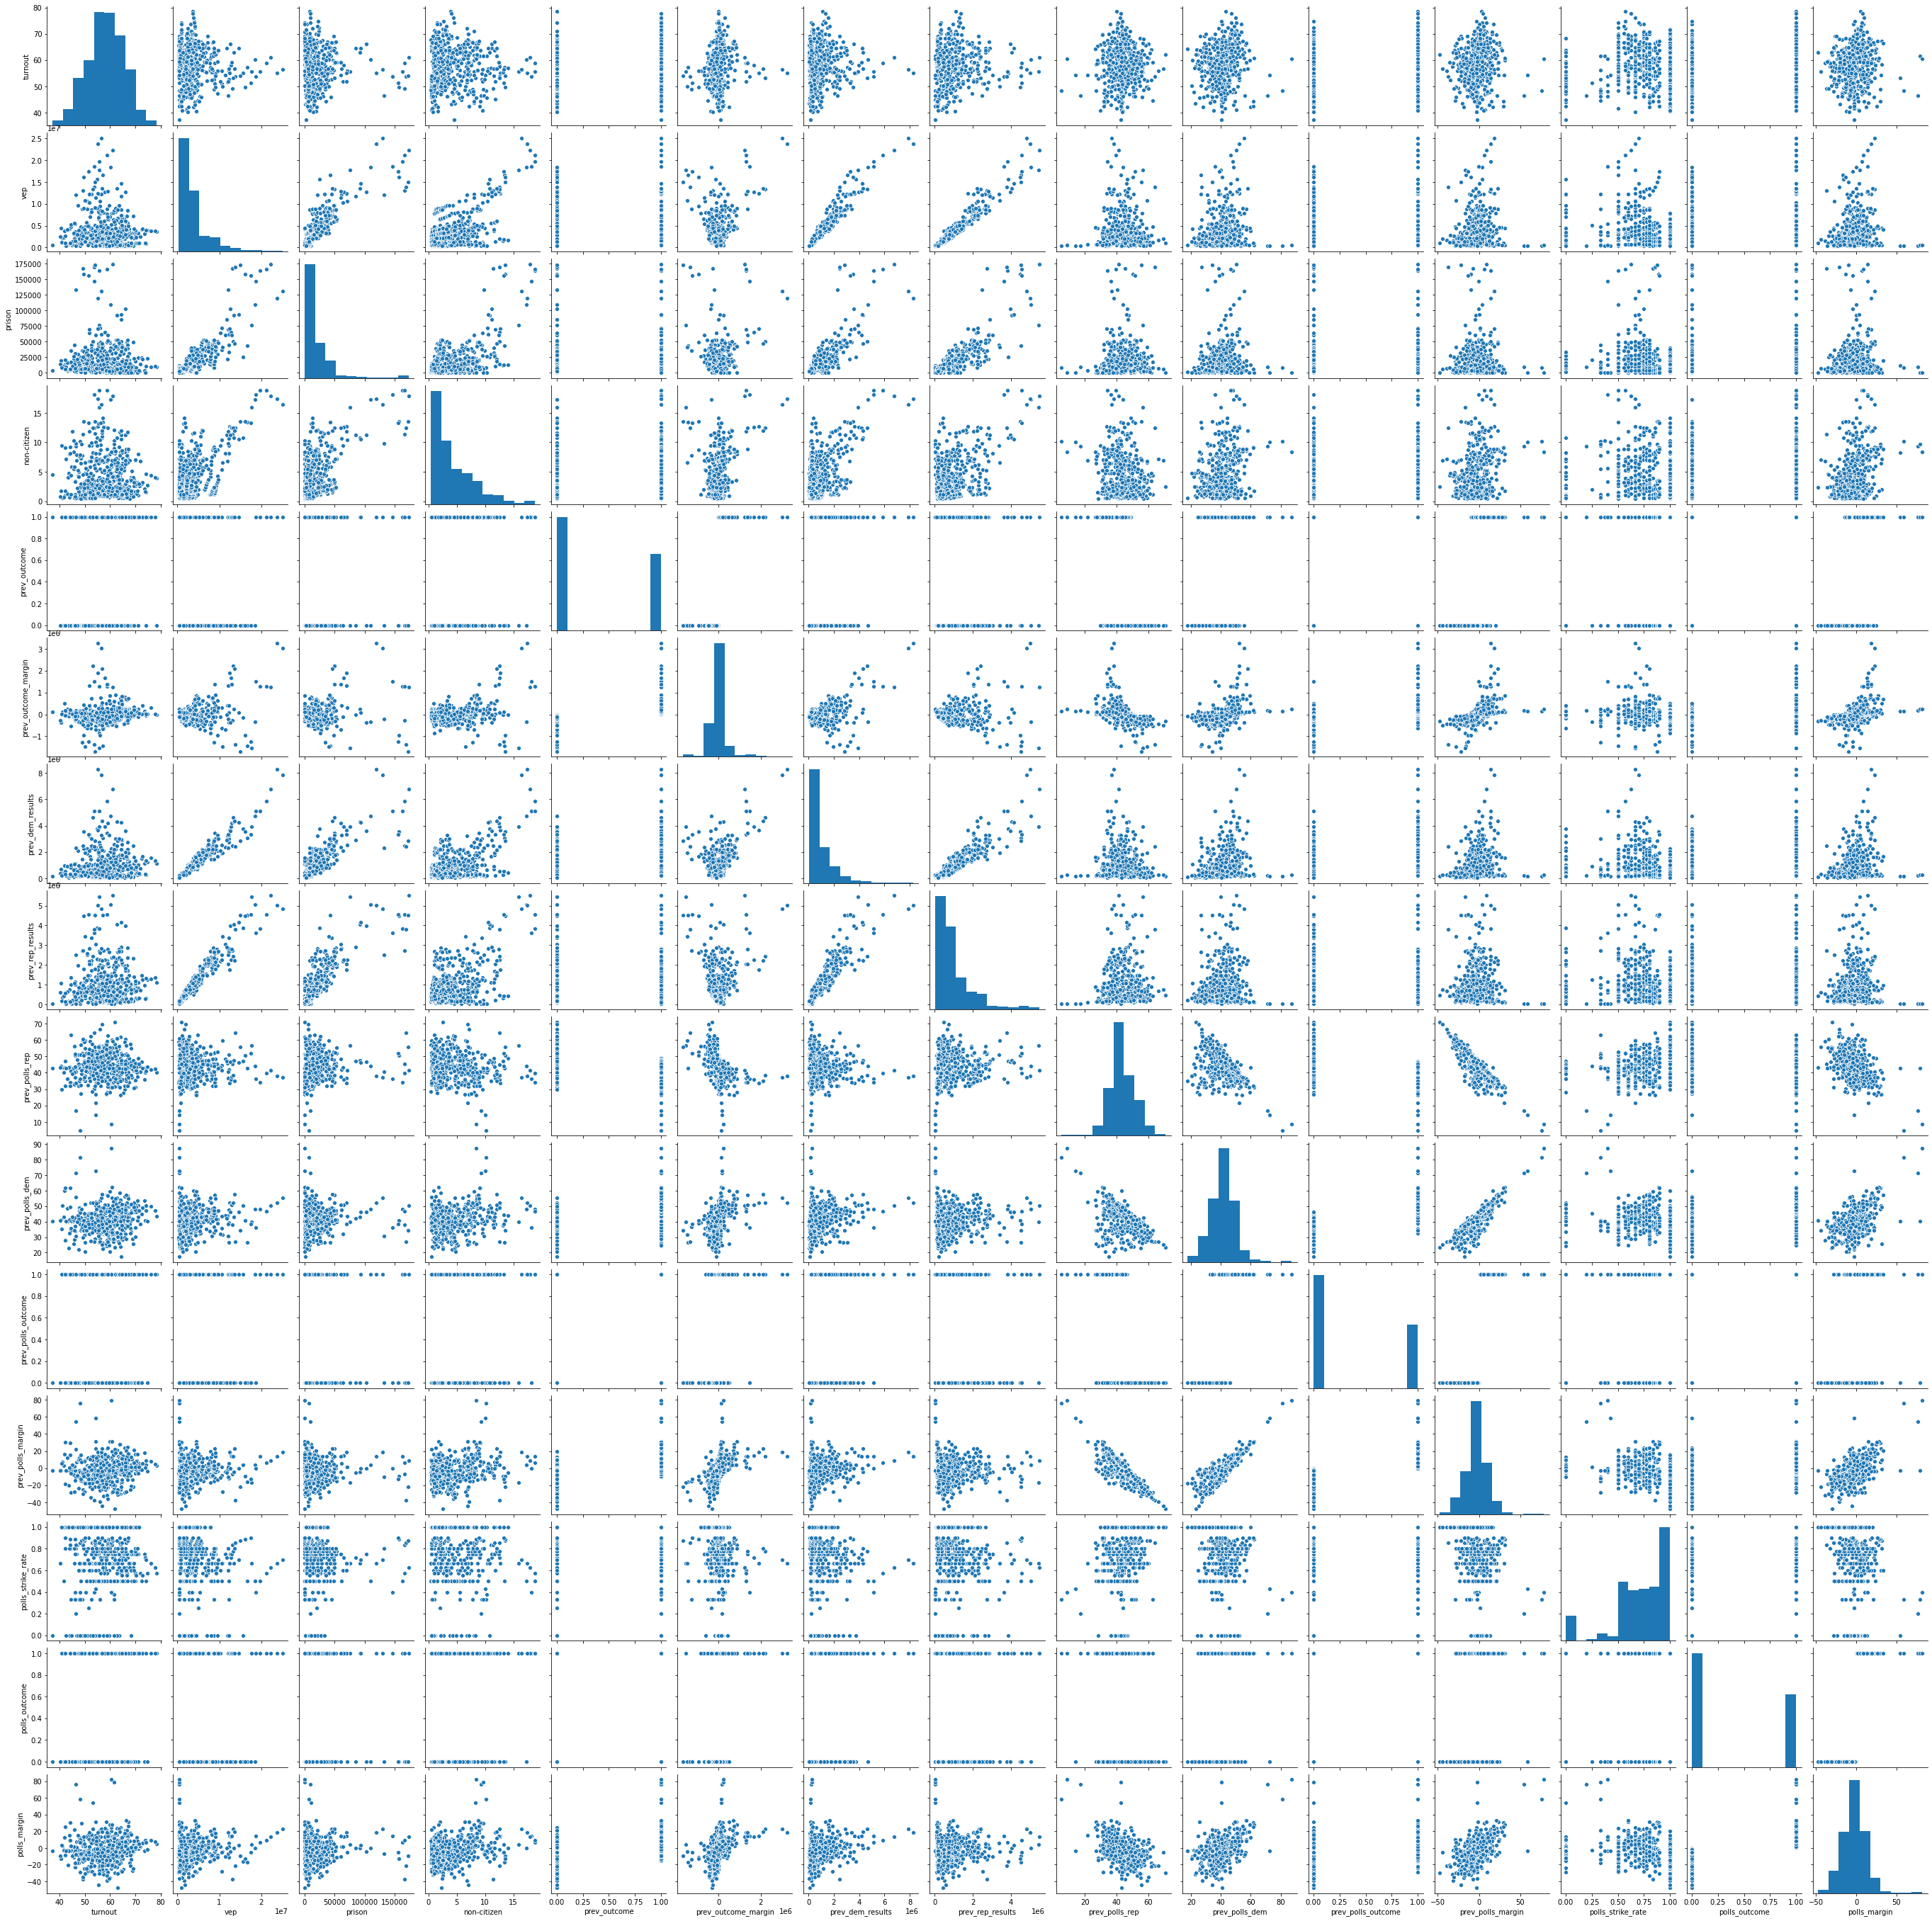

In [380]:
plot_data = train_data.drop('year', axis=1)
plot_data = plot_data.drop('outcome', axis=1)
plot_data = plot_data.drop('rep_polls', axis=1)
plot_data = plot_data.drop('dem_polls', axis=1)
sns.pairplot(plot_data)

We see that the non-citizen variable seems to be associated with vep, and non-citizen and prison population. We can also see that the results are correlated with polls. However, though there is a correlation, it does not seem as though the correlation is so close that polls can accurately predict results.

In [381]:
test_data.describe()

year  rep_polls  dem_polls    turnout           vep         prison  \
count    51.0  51.000000  51.000000  51.000000  5.100000e+01      51.000000   
mean   2020.0  45.804049  50.594716  67.770588  4.600645e+06   23718.529412   
std       0.0  10.690360  10.637241   6.031427  4.955501e+06   28213.565325   
min    2020.0  10.379750  31.410000  55.000000  4.313640e+05       0.000000   
25%    2020.0  38.298728  42.731487  64.550000  1.338126e+06    6080.500000   
50%    2020.0  45.784232  48.680059  67.600000  3.312250e+06   18099.000000   
75%    2020.0  53.123248  58.754497  72.550000  5.313422e+06   31207.500000   
max    2020.0  66.920750  87.118000  79.900000  2.596265e+07  154913.000000   

       non-citizen    outcome  prev_outcome  prev_outcome_margin  \
count    51.000000  51.000000     51.000000         5.100000e+01   
mean      5.443137   0.509804      0.411765         3.993577e+04   
std       3.249262   0.504878      0.497050         7.529340e+05   
min       0.900000   0.000000      0.000000        -8.071790e+05   
25%       3.000000   0.000000      0.000000        -2.720145e+05   
50%       4.300000   1.000000      0.000000        -1.015310e+05   
75%       7.400000   1.000000      1.000000         1.097950e+05   
max      15.000000   1.000000      1.000000         4.269978e+06   

       prev_dem_results  prev_rep_results  prev_polls_rep  prev_polls_dem  \
count      5.100000e+01      5.100000e+01       51.000000       51.000000   
mean       1.259955e+06      1.220019e+06       41.361353       42.099437   
std        1.544029e+06      1.139270e+06        9.831437       10.242368   
min        5.597300e+04      1.272300e+04        4.995670       21.081943   
25%        2.975840e+05      3.774225e+05       36.202036       35.565709   
50%        7.295470e+05      9.491360e+05       41.645006       42.581616   
75%        1.810340e+06      1.575898e+06       47.140285       45.591051   
max        8.753788e+06      4.685047e+06       66.272782       86.903725   

       prev_polls_outcome  prev_polls_margin  polls_strike_rate  polls_margin  \
count           51.000000          51.000000          51.000000     51.000000   
mean             0.529412           0.738083           0.652406      4.790668   
std              0.504101          19.295410           0.251084     21.276653   
min              0.000000         -36.491319           0.090909    -35.510750   
25%              0.000000         -11.011520           0.454545     -9.540018   
50%              1.000000           0.738457           0.636364      2.822746   
75%              1.000000           8.485828           0.909091     21.013775   
max              1.000000          81.908055           1.000000     76.738250   

       polls_outcome  
count      51.000000  
mean        0.549020  
std         0.502543  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         1.000000  
max         1.000000

In [382]:
train_data.describe()

year   rep_polls   dem_polls     turnout           vep  \
count   510.000000  510.000000  510.000000  510.000000  5.100000e+02   
mean   1998.000000   43.549303   40.945963   58.173922  3.725439e+06   
std      11.500406    8.696049    8.745180    7.226684  3.891914e+06   
min    1980.000000    4.928611   17.500813   37.200000  2.701220e+05   
25%    1988.000000   37.993944   35.523562   53.300000  9.998340e+05   
50%    1998.000000   43.299481   40.533745   58.550000  2.596743e+06   
75%    2008.000000   48.995148   45.939146   63.600000  4.515792e+06   
max    2016.000000   71.051819   87.395613   78.400000  2.510484e+07   

              prison  non-citizen     outcome  prev_outcome  \
count     510.000000   510.000000  510.000000    510.000000   
mean    18880.356863     4.334314    0.398039      0.401961   
std     27152.641749     3.646326    0.489974      0.490775   
min         0.000000     0.400000    0.000000      0.000000   
25%      3300.750000     1.500000    0.000000      0.000000   
50%      9379.500000     3.100000    0.000000      0.000000   
75%     23498.250000     6.600000    1.000000      1.000000   
max    173670.000000    18.800000    1.000000      1.000000   

       prev_outcome_margin  prev_dem_results  prev_rep_results  \
count         5.100000e+02      5.100000e+02      5.100000e+02   
mean         -8.528589e+03      9.632237e+05      9.717522e+05   
std           4.358661e+05      1.088110e+06      9.663610e+05   
min          -1.694213e+06      4.184200e+04      1.733900e+04   
25%          -1.837942e+05      2.340798e+05      2.755535e+05   
50%          -3.156100e+04      6.331475e+05      6.922410e+05   
75%           9.345475e+04      1.201189e+06      1.253201e+06   
max           3.262692e+06      8.274473e+06      5.509826e+06   

       prev_polls_rep  prev_polls_dem  prev_polls_outcome  prev_polls_margin  \
count      510.000000      510.000000          510.000000         510.000000   
mean        43.762065       40.953412            0.358824          -2.808653   
std          8.105255        8.290010            0.480126          14.176091   
min          4.928611       17.500813            0.000000         -47.882240   
25%         39.257440       35.976707            0.000000          -9.954401   
50%         43.300748       40.600995            0.000000          -2.693689   
75%         48.746348       45.875780            1.000000           4.568619   
max         71.051819       87.395613            1.000000          78.886376   

       polls_strike_rate  polls_outcome  polls_margin  
count         510.000000     510.000000    510.000000  
mean            0.727636       0.390196     -2.603340  
std             0.268998       0.488273     15.370723  
min             0.000000       0.000000    -47.882240  
25%             0.600000       0.000000    -11.342914  
50%             0.750000       0.000000     -3.233075  
75%             1.000000       1.000000      6.454159  
max             1.000000       1.000000     81.908055

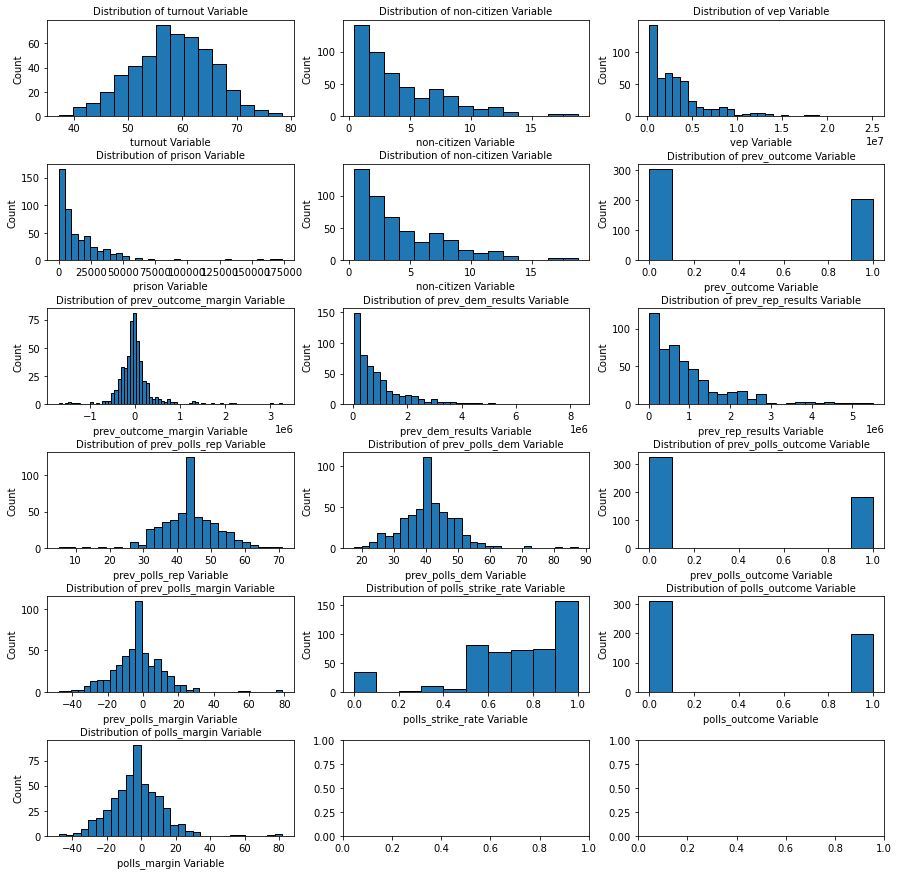

In [383]:
#Explore distributions of key demgraphic variables

df_2 = train_data.drop('state', axis=1)
df_3 = df_2.drop('outcome', axis=1)
df_3 = df_3.drop('year', axis=1)

fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.2)
axs = axs.ravel()
fontsize = 10

columns = ['turnout', 'non-citizen', 'vep', 'prison', 'non-citizen', 'prev_outcome', 'prev_outcome_margin', 'prev_dem_results', 'prev_rep_results', 'prev_polls_rep', 'prev_polls_dem', 'prev_polls_outcome', 'prev_polls_margin', 'polls_strike_rate', 'polls_outcome', 'polls_margin']

#columns = ['turnout'], ['vep'], ['prison'], ['non-citizen'], ['prev_outcome'], ['prev_outcome_margin'], ['prev_dem_results'], ['prev_rep_results'], ['prev_polls_rep'], ['prev_polls_dem'], ['prev_polls_outcome'], ['prev_polls_margin'], ['polls_strike_rate'], ['polls_outcome'], ['polls_margin']

# plot histograms
for i, feature in enumerate(columns):
    axs[i].hist(train_data[feature], bins='auto', density=False, histtype = 'bar', edgecolor='k')
    axs[i].set_title("Distribution of " + feature + " Variable", fontsize=fontsize)
    axs[i].set_xlabel(feature + " Variable", fontsize=fontsize)
    axs[i].set_ylabel('Count', fontsize=fontsize)


We can see that the prison population in a number of states is 0 or close to zero, and there is considerable variation in the prison population. We can also see that there are more outliers in results for democrat states, but the overall distribution of the results is slightly right-skewed. This suggests that Republicans tend to win more small states, and democrats win less states overall, but larger states, such as california.

In [384]:
train_data.dtypes

year                     int64
state                   object
rep_polls              float64
dem_polls              float64
turnout                float64
vep                      int64
prison                   int64
non-citizen            float64
outcome                  int64
prev_outcome             int64
prev_outcome_margin    float64
prev_dem_results       float64
prev_rep_results       float64
prev_polls_rep         float64
prev_polls_dem         float64
prev_polls_outcome       int64
prev_polls_margin      float64
polls_strike_rate      float64
polls_outcome            int64
polls_margin           float64
dtype: object

In [385]:
train_data_set, dev_data = train_test_split(train_data, test_size=100, random_state=22)

print(len(train_data_set), len(dev_data))

410 100


In [386]:
x_train = train_data_set.drop(['outcome','state'] , axis=1)
y_train = train_data_set['outcome']
x_dev = dev_data.drop(['outcome','state'], axis=1)
y_dev = dev_data['outcome']
x_test = test_data.drop(['outcome','state'], axis=1)
y_test = test_data['outcome']

In [387]:
predictors = x_train.columns


means_0 = x_train[y_train==0][predictors].mean()
means_1 = x_train[y_train==1][predictors].mean()
stds_0 = x_train[y_train==0][predictors].std()
stds_1 = x_train[y_train==1][predictors].std()
n1 = x_train[y_train==0].shape[0]
n2 = x_train[y_train==1].shape[0]

t_tests = np.abs(means_0-means_1)/np.sqrt( stds_0**2/n1 + stds_1**2/n2) 

best_preds_idx = np.argsort(-t_tests.values)
print('Ten best predictors: ')
print(t_tests[best_preds_idx[0:10]])

best_pred = t_tests.index[best_preds_idx[0]]
print('')
print('The best predictor is: ', best_pred)

Ten best predictors: 
polls_outcome          18.363748
polls_margin           16.841185
prev_outcome           15.773362
rep_polls              15.471839
dem_polls              12.016605
prev_polls_margin      11.984745
prev_polls_outcome     10.215288
prev_polls_dem          9.758663
prev_outcome_margin     9.336345
prev_polls_rep          9.241056
dtype: float64

The best predictor is:  polls_outcome


### 2. Feature Engineering

It is likely that the interaction of different variables will be useful to use. Firstly, we will add interactions between the top predictor and the other top-ten predictors. Also, it is likely that the proportiom of polls that have been successfully predicted will also interact with other polling data.

In [388]:
interaction1 = ['polls_outcome', 'polls_strike_rate']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [389]:
interaction1 = ['polls_outcome', 'polls_margin']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [390]:
interaction1 = ['prev_outcome', 'polls_outcome']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [391]:
interaction1 = ['polls_outcome', 'rep_polls']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [392]:
interaction1 = ['polls_outcome', 'dem_polls']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [393]:
interaction1 = ['polls_outcome', 'prev_polls_margin']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [394]:
interaction1 = ['polls_outcome', 'prev_polls_outcome']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [395]:
interaction1 = ['polls_outcome', 'prev_polls_dem']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [396]:
interaction1 = ['polls_outcome', 'prev_polls_outcome']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [397]:
interaction1 = ['polls_outcome', 'prev_polls_dem']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [398]:
interaction1 = ['polls_outcome', 'prev_outcome_margin']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [399]:
interaction1 = ['polls_margin', 'polls_strike_rate']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [400]:
interaction1 = ['polls_margin', 'prev_outcome']
for df in [x_train, x_dev, x_test, train_data]:
    df["&".join(interaction1)] = df[interaction1[0]] * df[interaction1[1]]

In [401]:
predictors = x_train.columns


means_0 = x_train[y_train==0][predictors].mean()
means_1 = x_train[y_train==1][predictors].mean()
stds_0 = x_train[y_train==0][predictors].std()
stds_1 = x_train[y_train==1][predictors].std()
n1 = x_train[y_train==0].shape[0]
n2 = x_train[y_train==1].shape[0]

t_tests = np.abs(means_0-means_1)/np.sqrt( stds_0**2/n1 + stds_1**2/n2) 

best_preds_idx = np.argsort(-t_tests.values)
print('Ten best predictors: ')
print(t_tests[best_preds_idx[0:10]])

best_pred = t_tests.index[best_preds_idx[0]]
print('')
print('The best predictor is: ', best_pred)

Ten best predictors: 
polls_outcome                      18.363748
polls_outcome&dem_polls            18.168084
polls_outcome&prev_polls_dem       18.116327
polls_margin&polls_strike_rate     17.616582
polls_margin                       16.841185
polls_outcome&rep_polls            16.711381
polls_outcome&polls_strike_rate    16.057618
prev_outcome                       15.773362
rep_polls                          15.471839
prev_outcome&polls_outcome         14.471770
dtype: float64

The best predictor is:  polls_outcome


Several of the interactions are now in the naive top-ten predictors, including polls_margin&polls_strike_rate. 

### 3. Modeling

####  3a. Logistic regression

In [402]:
np.random.seed(121)

accuracies = {'Train': {}, 'Dev': {}}

#x_train = train_data[['polls']]
#y_train = train_data['outcome']
#x_test = test_data[['polls']]
#y_test = test_data['outcome']

logit_1 = LogisticRegression(penalty='none', max_iter = 1000)



logit_1.fit(x_train[['polls_outcome']],y_train)


Beta_0 = logit_1.intercept_[0]
Beta_1 = logit_1.coef_[0][0]

train_accuracy = logit_1.score(x_train[['polls_outcome']], y_train)
dev_accuracy = logit_1.score(x_dev[['polls_outcome']], y_dev)
print(f'The train accuracy is {round(train_accuracy,3)}')
print(f'The dev accuracy is {round(dev_accuracy, 3)}')

print("Logistic Regression Estimated Betas (Beta0 and Beta1):",round(Beta_0,3),round(Beta_1,3))

accuracies['Train']['Logistic regression (single predictor)'] = train_accuracy
accuracies['Dev']['Logistic regression (single predictor)'] = dev_accuracy

The train accuracy is 0.856
The dev accuracy is 0.81
Logistic Regression Estimated Betas (Beta0 and Beta1): -1.885 3.511


In [403]:
np.random.seed(121)

#x_train = train_data[['polls']]
#y_train = train_data['outcome']
#x_test = test_data[['polls']]
#y_test = test_data['outcome']

logit_1 = LogisticRegression(penalty='none', max_iter = 1000)



logit_1.fit(x_train,y_train)


Beta_0 = logit_1.intercept_[0]
Beta_1 = logit_1.coef_[0][0]

train_accuracy = logit_1.score(x_train, y_train)
dev_accuracy = logit_1.score(x_dev, y_dev)
print(f'The train accuracy is {round(train_accuracy,3)}')
print(f'The dev accuracy is {round(dev_accuracy, 3)}')

accuracies['Train']['Logistic regression (all predictors)'] = train_accuracy
accuracies['Dev']['Logistic regression (all predictors)'] = dev_accuracy

The train accuracy is 0.81
The dev accuracy is 0.81


In [404]:
features = list(x_train.columns.values)
coefs = pd.DataFrame(logit_1.coef_[0], columns=['Coefficients'], index=features)
sorted_coefs = coefs.sort_values(by=['Coefficients'], ascending=False)
sorted_coefs

Coefficients
polls_outcome&dem_polls            1.339590e-05
polls_outcome&prev_polls_dem       1.168530e-05
prison                             1.102512e-05
polls_outcome&rep_polls            9.619793e-06
polls_margin                       8.973189e-06
polls_margin&polls_strike_rate     6.417748e-06
prev_outcome_margin                5.103057e-06
prev_dem_results                   4.391177e-06
polls_outcome&polls_margin         3.776103e-06
prev_polls_margin                  3.607751e-06
polls_margin&prev_outcome          3.531719e-06
non-citizen                        7.930139e-07
polls_outcome&prev_polls_margin    5.860022e-07
polls_outcome                      2.789122e-07
polls_outcome&polls_strike_rate    1.949697e-07
prev_outcome&polls_outcome         1.667145e-07
polls_outcome&prev_polls_outcome   1.407698e-07
prev_outcome                       9.603725e-08
prev_polls_outcome                 8.217698e-08
polls_strike_rate                 -8.775222e-08
dem_polls                         -4.821590e-07
prev_rep_results                  -7.118797e-07
vep                               -9.513649e-07
polls_outcome&prev_outcome_margin -2.325118e-06
prev_polls_dem                    -2.581177e-06
turnout                           -5.799474e-06
prev_polls_rep                    -6.188928e-06
rep_polls                         -9.455348e-06
year                              -2.154259e-04

In [405]:
Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 5
penalty = 'l1'
solver = 'liblinear'

logit_lasso = LogisticRegressionCV(
    Cs=Cs, cv=cv, penalty=penalty, solver='liblinear'
).fit(x_train, y_train)

logit_lasso_score_train = round(logit_lasso.score(x_train, y_train),3)
logit_lasso_score_dev = round(logit_lasso.score(x_dev, y_dev), 3)


print('The train accuracy is', logit_lasso_score_train)
print('The dev accuracy is', logit_lasso_score_dev)

accuracies['Train']['Logistic regression (with Lasso)'] = logit_lasso_score_train
accuracies['Dev']['Logistic regression (with Lasso)'] = logit_lasso_score_dev

C:\Users\phili\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\phili\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


The train accuracy is 0.905
The dev accuracy is 0.92


In [406]:
#train_data_2016_dummy = train_data[(train_data.year == 2016)]
#logit_lasso_preds = logit_lasso.predict_proba(train_data_2016_dummy.drop('state'), axis=1)
#train_data_2016_dummy['preds'] = logit_lasso_preds[:,1]

In [407]:
# your code here
lasso_coefs = list(logit_lasso.coef_[0])
lasso_coefs_abs = list(map(abs, lasso_coefs))
sorted_coefs = sorted(lasso_coefs_abs)
important_coefs = sorted_coefs[-200:]
most_important_coefs = [i for i in important_coefs if i > 0]
num_important_predictors = len(most_important_coefs)
print(f'There are {num_important_predictors} predictors with a coefficient over 0')

There are 17 predictors with a coefficient over 0


In [408]:
features = list(x_train.columns.values)
coefs = pd.DataFrame(logit_lasso.coef_[0], columns=['Coefficients'], index=features)
sorted_coefs = coefs.sort_values(by=['Coefficients'], ascending=False)
sorted_coefs

Coefficients
non-citizen                        2.203476e-01
polls_margin                       1.553806e-01
polls_margin&polls_strike_rate     1.026551e-01
prev_polls_margin                  1.003902e-01
turnout                            4.132899e-02
polls_outcome&rep_polls            1.680603e-02
year                               8.802097e-04
prison                             1.312369e-05
polls_outcome&prev_outcome_margin  1.293545e-06
prev_outcome_margin                8.624289e-07
prev_rep_results                   8.023110e-07
prev_dem_results                   5.943185e-07
prev_outcome                       0.000000e+00
dem_polls                          0.000000e+00
polls_outcome&prev_polls_outcome   0.000000e+00
polls_outcome&dem_polls            0.000000e+00
prev_outcome&polls_outcome         0.000000e+00
polls_outcome&polls_margin         0.000000e+00
polls_outcome&polls_strike_rate    0.000000e+00
polls_outcome                      0.000000e+00
polls_strike_rate                  0.000000e+00
prev_polls_outcome                 0.000000e+00
prev_polls_dem                     0.000000e+00
prev_polls_rep                     0.000000e+00
vep                               -4.182462e-07
polls_outcome&prev_polls_dem      -2.072704e-02
polls_outcome&prev_polls_margin   -2.192183e-02
polls_margin&prev_outcome         -5.298258e-02
rep_polls                         -1.190902e-01

We can see that Lasso has reduced a number of coefficients to zero, including prev_outcome. let's see what happens to the features when they are bootstrapped across models.

In [409]:
num_bootstraps = 100
bootstrap_coefs = []
train_accuracies = []
dev_accuracies = []
selected_features = []
candidate_features = features[1:]
mse_across_features = []

best_acc = 0.1

Cs = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]
cv = 5
penalty = 'l1'
solver = 'liblinear'

# bootstrapping will shuffle the rows, so we need to ensure
# that the y's maintain the same order as the x's
merged = pd.concat([x_train, y_train], axis=1, sort=False)

for i in range(num_bootstraps):

    boot_df = merged.sample(frac=1, replace=True)

    xtrain_boot = boot_df.drop(["outcome"], axis=1)
    ytrain_boot = boot_df["outcome"]
    
    boot_log = LogisticRegressionCV(
    Cs=Cs, cv=cv, penalty=penalty, solver='liblinear', max_iter=10000,
).fit(xtrain_boot, ytrain_boot)
    
    # evaluate on the train set
    y_train_pred_boot = boot_log.predict(xtrain_boot)
    
    logit_lasso_score_train = round(logit_lasso.score(xtrain_boot, ytrain_boot),3)
    
    train_accuracies.append(logit_lasso_score_train)

    # evaluate on the dev set
    y_dev_pred_boot = boot_log.predict(x_dev)
    logit_lasso_score_dev = round(logit_lasso.score(x_dev, y_dev), 3)
    
    dev_accuracies.append(logit_lasso_score_dev)
    
    bootstrap_coefs.append(boot_log.coef_)

bootstrap_coefs = np.array(bootstrap_coefs)
print("train_accuracies:", np.mean(train_accuracies))
print("dev_accuracies:", np.mean(dev_accuracies))

C:\Users\phili\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\phili\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\phili\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\phili\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


train_accuracies: 0.90605
dev_accuracies: 0.9200000000000002


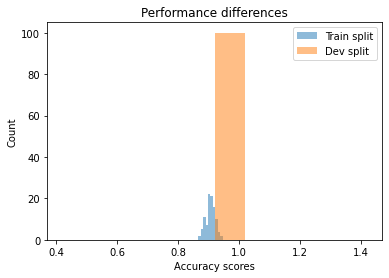

In [410]:
plt.figure(figsize=(6,4))
plt.hist(train_accuracies, bins=10, alpha=0.5, label="Train split")
plt.hist(dev_accuracies, bins=10, alpha=0.5, label="Dev split")

plt.xlabel("Accuracy scores", size=10)
plt.ylabel("Count", size=10)
plt.title("Performance differences")
plt.legend(loc='upper right')

We can clearly see that the train split and dev split overlap, which suggests that the Lasso model is relatively robust across bootstraps.

####  3b. Logistic regression with PCA

In [411]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scale_transformer = StandardScaler(copy=True).fit(x_train)
x_train_scaled = scale_transformer.transform(x_train)
x_dev_scaled = scale_transformer.transform(x_dev)

pca = PCA().fit(x_train_scaled)

# transforming the dataframe
x_train_pca = pca.transform(x_train_scaled)
x_dev_pca = pca.transform(x_dev_scaled)

print('Dimensions of transformed x_train:', x_train_pca.shape)
print('Dimensions of transformed x_test', x_dev_pca.shape)

Dimensions of transformed x_train: (410, 29)
Dimensions of transformed x_test (100, 29)


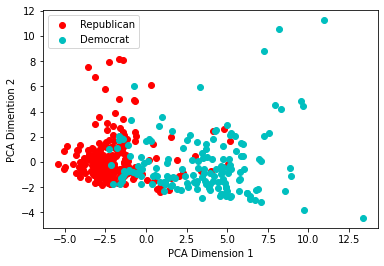

In [412]:
colors = ['r','c']
label_text = ["Republican", "Democrat"]

# and we loop over the different groups
for cur_quality in [0,1]:
    cur_df = x_train_pca[y_train==cur_quality]
    plt.scatter(cur_df[:,0], cur_df[:,1], c = colors[cur_quality], label=label_text[cur_quality])

# all plots need labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend();

Roughly 4 PCs are needed to explain 90% of the variability in the predictors
The amount of variance in predictors explained by the first two principal components is 0.422


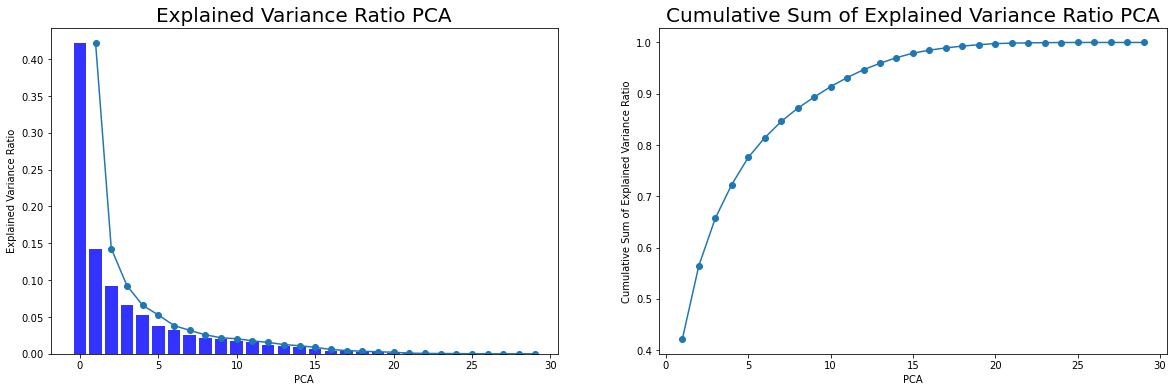

In [413]:
pca_2_variance_expl = pca.explained_variance_ratio_[0:1]
v_expl = round(pca_2_variance_expl[0],3)
fig, ax = plt.subplots(ncols=2, figsize=(20,6))
ax1,ax2 = ax.ravel()

ratio = pca.explained_variance_ratio_
ax1.bar(range(len(ratio)), ratio, color='blue', alpha=0.8)
ax1.plot(range(1,len(ratio)+1), ratio, 'o-')
ax1.set_ylabel('Explained Variance Ratio')
ax1.set_title('Explained Variance Ratio PCA', fontsize=20)
ax1.set_xlabel('PCA');

ratio = pca.explained_variance_ratio_
ax2.plot(range(1,len(ratio)+1), np.cumsum(ratio), 'o-')
ax2.set_title('Cumulative Sum of Explained Variance Ratio PCA', fontsize=20)
ax2.set_ylabel('Cumulative Sum of Explained Variance Ratio');
ax2.set_xlabel('PCA');

print('Roughly 4 PCs are needed to explain 90% of the variability in the predictors')
print(f'The amount of variance in predictors explained by the first two principal components is {v_expl}')

In [414]:
#Using 2 PCs
pca_2 = PCA(n_components=2).fit(x_train_scaled)
x_train_pca_2 = pca_2.transform(x_train_scaled)
x_dev_pca_2 = pca_2.transform(x_dev_scaled)

print('Original dimensions:', x_train_scaled.shape)
print('PCA dimensions:     ', x_train_pca_2.shape)

#Training a logistic regression model
logistic_pca_2 = LogisticRegressionCV(max_iter=10000, cv=10).fit(x_train_pca_2, y_train)

#Predict
y_pred_train = logistic_pca_2.predict(x_train_pca_2)
y_pred_dev = logistic_pca_2.predict(x_dev_pca_2)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)
dev_score = accuracy_score(y_dev, y_pred_dev)
print("Training Set Accuracy:",str(train_score))
print("Dev Set Accuracy:",str(dev_score))
accuracies['Train']['Logistic regression (with 2 principle components)'] = train_score
accuracies['Dev']['Logistic regression (with 2 principle components)'] = dev_score

Original dimensions: (410, 29)
PCA dimensions:      (410, 2)
Training Set Accuracy: 0.8707317073170732
Dev Set Accuracy: 0.84


In [415]:
#Using 5 PCs
pca_50 = PCA(n_components=15).fit(x_train_scaled)
x_train_pca_2 = pca_50.transform(x_train_scaled)
x_dev_pca_2 = pca_50.transform(x_dev_scaled)

print('Original dimensions:', x_train_scaled.shape)
print('PCA dimensions:     ', x_train_pca_2.shape)

#Training a logistic regression model
logistic_pca_2 = LogisticRegressionCV(max_iter=10000, cv=10).fit(x_train_pca_2, y_train)

#Predict
y_pred_train = logistic_pca_2.predict(x_train_pca_2)
y_pred_dev = logistic_pca_2.predict(x_dev_pca_2)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
dev_score = accuracy_score(y_dev, y_pred_dev)*100
print("Training Set Accuracy:",str(train_score)+'%')
print("Dev Set Accuracy:",str(dev_score)+'%')
accuracies['Train']['Logistic regression (with 15 principle components)'] = train_accuracy
accuracies['Dev']['Logistic regression (with 15 principle components)'] = dev_accuracy

Original dimensions: (410, 29)
PCA dimensions:      (410, 15)
Training Set Accuracy: 90.73170731707317%
Dev Set Accuracy: 88.0%


In [416]:
predictors = [['year'], ['rep_polls'], ['dem_polls'], ['turnout'], ['vep'], ['prison'], ['non-citizen'], ['prev_outcome'], ['prev_outcome_margin'], ['prev_dem_results'], ['prev_rep_results'], ['prev_polls_rep'], ['prev_polls_dem'], ['prev_polls_outcome'], ['prev_polls_margin'], ['polls_strike_rate'], ['polls_outcome'], ['polls_margin']]

####  3c. KNN

In [417]:
# create and fit a kNN classifier
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

# evaluate on the training set
y_train_pred = knn_model.predict(x_train)
acc_train = knn_model.score(x_train, y_train)

# evaluate on the dev set
y_dev_pred = knn_model.predict(x_dev)
acc_dev = knn_model.score(x_dev, y_dev)

print("train accuracy:", acc_train, "dev accuracy:", acc_dev)
accuracies['Train']['KNN (k=5)'] = acc_train
accuracies['Dev']['KNN (k=5)'] = acc_dev

train accuracy: 0.8731707317073171 dev accuracy: 0.8


In [418]:
max_k = 20
train_accs = []
dev_accs = []

for k in range(1, max_k):

    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(x_train, y_train)

    
    # evaluate on the training set
    y_train_pred = knn_model.predict(x_train)
    acc_train = knn_model.score(x_train, y_train)

    # evaluate on the dev set
    y_dev_pred = knn_model.predict(x_dev)
    acc_dev = knn_model.score(x_dev, y_dev)


    # evaluate on the training set
    y_train_pred = knn_model.predict(x_train)
    train_acc = round(mean_squared_error(y_train, y_train_pred), 5)
    train_accs.append(acc_train)
    
    # evaluate on the dev set
    y_dev_pred = knn_model.predict(x_dev)
    dev_MSE = round(mean_squared_error(y_dev, y_dev_pred), 5)
    dev_accs.append(acc_dev)
    
    print("k:", k, "train_acc:", acc_train, "dev_acc:", acc_dev)
print("*** best result was k =", np.argmax(dev_accs) + 1, ":", np.max(dev_accs))

k: 1 train_acc: 1.0 dev_acc: 0.76
k: 2 train_acc: 0.8780487804878049 dev_acc: 0.78
k: 3 train_acc: 0.8951219512195122 dev_acc: 0.76
k: 4 train_acc: 0.8512195121951219 dev_acc: 0.78
k: 5 train_acc: 0.8731707317073171 dev_acc: 0.8
k: 6 train_acc: 0.8536585365853658 dev_acc: 0.78
k: 7 train_acc: 0.848780487804878 dev_acc: 0.76
k: 8 train_acc: 0.8292682926829268 dev_acc: 0.78
k: 9 train_acc: 0.8292682926829268 dev_acc: 0.78
k: 10 train_acc: 0.8121951219512196 dev_acc: 0.77
k: 11 train_acc: 0.8268292682926829 dev_acc: 0.76
k: 12 train_acc: 0.8097560975609757 dev_acc: 0.76
k: 13 train_acc: 0.8292682926829268 dev_acc: 0.8
k: 14 train_acc: 0.8219512195121951 dev_acc: 0.78
k: 15 train_acc: 0.8439024390243902 dev_acc: 0.8
k: 16 train_acc: 0.8146341463414634 dev_acc: 0.78
k: 17 train_acc: 0.824390243902439 dev_acc: 0.79
k: 18 train_acc: 0.8097560975609757 dev_acc: 0.78
k: 19 train_acc: 0.8195121951219512 dev_acc: 0.78
*** best result was k = 5 : 0.8


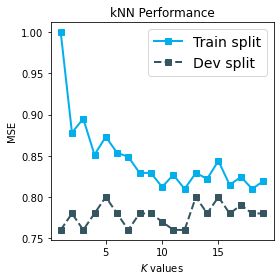

In [419]:
# Vizualization
ind = [_ + 1 for _ in range(max_k-1)]
fig, ax = plt.subplots(1,1, figsize=(4,4))
ax.plot(ind, train_accs, 's-', label='Train split',color='#02afed',linewidth=2)
ax.plot(ind, dev_accs, 's--', label='Dev split',color='#355561',linewidth=2)
ax.set_xlabel(r'$K$ values', fontsize=10)
ax.set_ylabel('MSE', fontsize=10)
ax.set_title(r'kNN Performance')
ax.legend(fontsize=14)
fig.tight_layout()

In [420]:
# create and fit a kNN classifier
k = 5
knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(x_train, y_train)

# evaluate on the training set
y_train_pred = knn_model.predict(x_train)
acc_train = knn_model.score(x_train, y_train)

# evaluate on the dev set
y_dev_pred = knn_model.predict(x_dev)
acc_dev = knn_model.score(x_dev, y_dev)

print("train accuracy:", acc_train, "dev accuracy:", acc_dev)
accuracies['Train']['KNN Optimised - (k=5)'] = acc_train
accuracies['Dev']['KNN Optimised - (k=5)'] = acc_dev

train accuracy: 0.8731707317073171 dev accuracy: 0.8


####  3d. Decision Trees and Random Forest

In [421]:
#Find optimal depth of trees
mean_CV_acc = {}
all_CV_acc = {}
tree_depth_start, tree_depth_end, steps = 3, 31, 4
for i in range(tree_depth_start, tree_depth_end + 1, steps):
    model = DecisionTreeClassifier(max_depth=i)
    score = cross_val_score(estimator=model, X=x_train, y=y_train, cv=5, n_jobs=-1)
    all_CV_acc[i] = score
    mean_CV_acc[i] = score.mean()

In [422]:
x = list(mean_CV_acc.keys())
y = list(mean_CV_acc.values())
lists = sorted(mean_CV_acc.items())
x, y = zip(*lists)

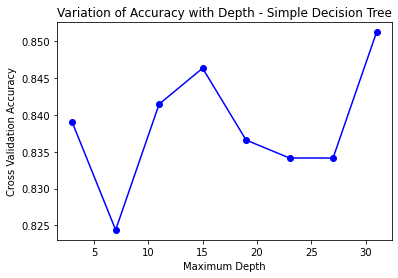

In [423]:
#Plot
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

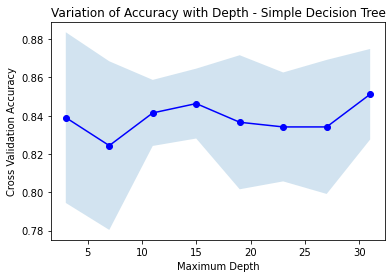

In [424]:
stds = np.array([ np.std(score) for score in all_CV_acc.values() ])
plt.fill_between(x, y + stds, y - stds, alpha=0.2)

#Plot
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

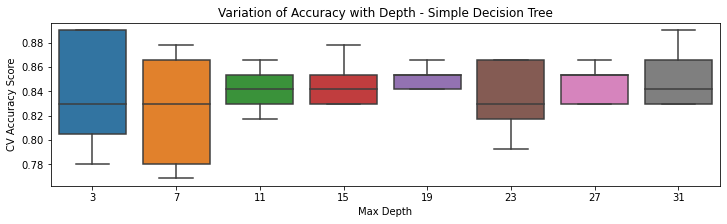

In [425]:
# Making a numpy array with all the CV acc scores
scores_numpy = np.array(list(all_CV_acc.values()))
# Making a datafr
trees = pd.DataFrame({'Max Depth':x+x+x+x+x, 'CV Accuracy Score':list(scores_numpy[:,0])+
                     list(scores_numpy[:,1])+
                     list(scores_numpy[:,2])+
                     list(scores_numpy[:,3])+
                     list(scores_numpy[:,4])})
# plotting the boxplot without outliers (showfliers = False)
plt.figure(figsize=(12, 3))
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
sns.boxplot(x="Max Depth", y="CV Accuracy Score", data=trees, showfliers=False);

In [426]:
decision_model = DecisionTreeClassifier(max_depth=3)
decision_model.fit(x_train, y_train)

train_acc = decision_model.score(x_train, y_train)
dev_acc = decision_model.score(x_dev, y_dev)
accuracies['Train']['Decision Tree (depth 3)'] = train_acc
accuracies['Dev']['Decision Tree (depth 3)'] = dev_acc

Now we can try using a Random Forest Classifier. This will let us avoid overfitting through randomly selecting a subset of predictions

In [427]:
#Fit a Random Forest Model

num_features = int(np.sqrt(x_train.shape[1]))

#Training
model_rf = RandomForestClassifier(n_estimators=20, max_features = num_features, max_depth=40)
model_rf.fit(x_train, y_train)

y_pred_dev = model_rf.predict(x_dev)
y_pred_train = model_rf.predict(x_train)
#y_pred_test = model_rf.predict(x_test)

random_forest_train_score = accuracy_score(y_train, y_pred_train)
random_forest_dev_score = accuracy_score(y_dev, y_pred_dev)
#random_forest_test_score = accuracy_score(y_test, y_pred_test)

print("Random Forest: Accuracy, Train Set :  {:0.2f}".format(random_forest_train_score))
print("Random Forest: Accuracy, Dev Set :  {:0.2f}".format(random_forest_dev_score))
#print("Random Forest: Accuracy, Test Set :  {:0.2f}".format(random_forest_test_score))

Random Forest: Accuracy, Train Set :  1.00
Random Forest: Accuracy, Dev Set :  0.88


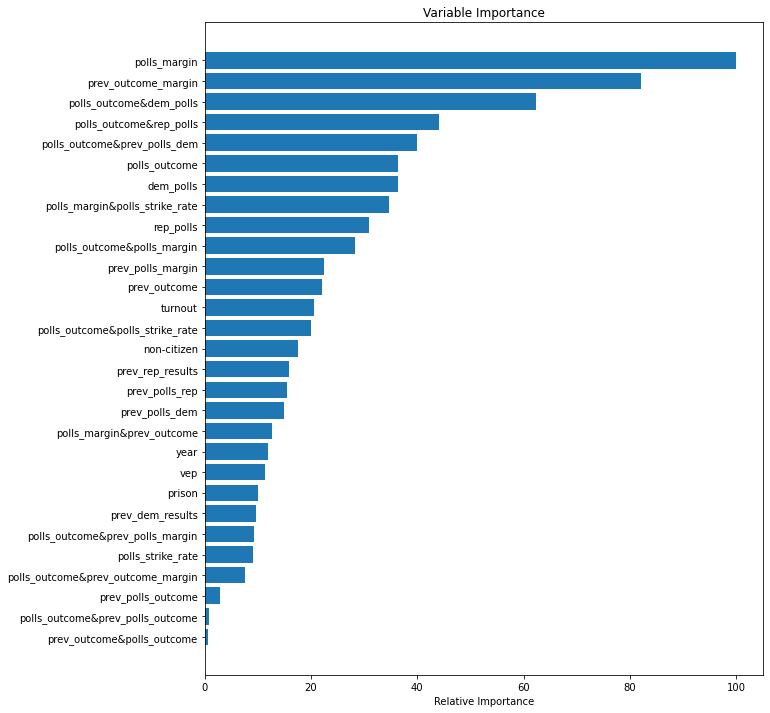

In [428]:
#Top Features
feature_importance = model_rf.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [429]:
def get_top_nodes(model, n = 0):
    rf_estimators = model.estimators_.copy()
    features = x_train.columns
    
    node_impurities, node_features = [], []

    for i, estimator in enumerate(rf_estimators):
        estimator_feature  = features[estimator.tree_.feature[n]]
        
        #node_impurities.append(estimator_impurity)
        node_features.append(estimator_feature)
    node_dict = {"feature": node_features}
    df = pd.Series(node_features)
    return(df)

In [430]:
top_predictors_rf = get_top_nodes(model_rf, n=20)

In [431]:
print(f'Top nodes in the random forest: {top_predictors_rf}') 

Top nodes in the random forest: 0                            turnout
1     polls_margin&polls_strike_rate
2                               year
3     polls_margin&polls_strike_rate
4                     prev_polls_dem
5     polls_margin&polls_strike_rate
6     polls_margin&polls_strike_rate
7                   prev_rep_results
8                   prev_rep_results
9     polls_margin&polls_strike_rate
10    polls_margin&polls_strike_rate
11                  prev_rep_results
12    polls_margin&polls_strike_rate
13                 polls_strike_rate
14    polls_margin&polls_strike_rate
15    polls_margin&polls_strike_rate
16    polls_margin&polls_strike_rate
17    polls_margin&polls_strike_rate
18    polls_margin&polls_strike_rate
19    polls_margin&polls_strike_rate
dtype: object


It makes sense that the most important predictor is polls_margin because this has more information content than polls_outcome (it not only tells us the outcome of the polling but the actual margin of the outcome). However, it is notable to see that the top nodes do not tally with the feature importance exactly.

C:\Users\phili\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\phili\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\phili\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\phili\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:544: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /
C:\Users\phili\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:540: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were 

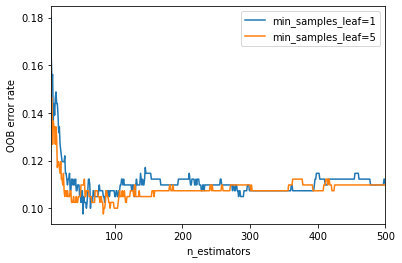

Wall time: 1min 32s


In [432]:
%%time
from collections import OrderedDict
ensemble_clfs = [
    (1,
        RandomForestClassifier(warm_start=True, 
                               min_samples_leaf=1,
                               oob_score=True,
                               max_depth = 10,
                               random_state=22)),
    (5,
        RandomForestClassifier(warm_start=True, 
                               min_samples_leaf=5,
                               oob_score=True,
                               max_depth = 10,
                               random_state=22))
]

# Map a label (the value of `min_samples_leaf`) to a list of (model, oob error) tuples.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 5
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i) 
        clf.fit(x_train, y_train)

        # Record the OOB error for each model. Error is 1 - oob_score
        # oob_score: score of the training dataset obtained using an 
        # out-of-bag estimate.
        # OOB error rate is % of num_missclassified/total observations
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=f'min_samples_leaf={label}')

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

Based on this graph it seems that the optimal number of estimators is around 205, with a min_sample_leaf of 1.

In [433]:
#Fit a Random Forest Model

num_features = int(np.sqrt(x_train.shape[1]))

#Training
model_rf = RandomForestClassifier(n_estimators=150, max_features = num_features, max_depth=40, min_samples_leaf = 1)
model_rf.fit(x_train, y_train)

y_pred_dev = model_rf.predict(x_dev)
y_pred_train = model_rf.predict(x_train)
#y_pred_test = model_rf.predict(x_test)

random_forest_train_score = accuracy_score(y_train, y_pred_train)
random_forest_dev_score = accuracy_score(y_dev, y_pred_dev)
#random_forest_test_score = accuracy_score(y_test, y_pred_test)

print("Random Forest: Accuracy, Train Set :  {:0.2f}".format(random_forest_train_score))
print("Random Forest: Accuracy, Dev Set :  {:0.2f}".format(random_forest_dev_score))
#print("Random Forest: Accuracy, Test Set :  {:0.2f}".format(random_forest_test_score))

accuracies['Train']['Random Forest Classifier'] = random_forest_train_score
accuracies['Dev']['Random Forest Classifier'] = random_forest_dev_score

Random Forest: Accuracy, Train Set :  1.00
Random Forest: Accuracy, Dev Set :  0.88


####  3e. Neural Network

In [434]:
#Scale all of these 
#Get all train data into the x_train
scaler = StandardScaler()
X_train = x_train.values
y_train = train_data['outcome'].values
X_train = scaler.fit_transform(train_data.drop(['outcome', 'state'], axis=1))

X_test = x_test.values
X_test = scaler.fit_transform(X_test)
y_test = y_test.values
X_dev = x_dev.values
X_dev = scaler.fit_transform(X_dev)

In [435]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (510, 29)
X_test shape:  (51, 29)
y_train shape:  (510,)
y_test shape:  (51,)


In [436]:
n_neurons = 15
n_input = len(X_train[0])
n_output = 1

myl2_reg = regularizers.l2(0.09)
myl1_reg = regularizers.l1(0.004) 

NN_model = tf.keras.models.Sequential(name='NN_model')

#First hidden layer
NN_model.add((tf.keras.layers.Dense(n_neurons,activation = 'relu', kernel_regularizer=myl2_reg, input_dim=n_input)))

#Second hidden layer
NN_model.add((tf.keras.layers.Dense(n_neurons,activation = 'relu', kernel_regularizer=myl2_reg)))

NN_model.add(tf.keras.layers.Dropout(0.2))

# output layer, one neuron 
NN_model.add(tf.keras.layers.Dense(n_output,  activation='sigmoid'))

NN_model.summary()

#Do we need to reshape in order for keras to use the data properly?
#How do we choose softmax vs linear for output and activation and optimiser/ loss functiom combo?

Model: "NN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15)                450       
_________________________________________________________________
dense_1 (Dense)              (None, 15)                240       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16        
Total params: 706
Trainable params: 706
Non-trainable params: 0
_________________________________________________________________


In [437]:
%%time
optimizer = optimizers.Adam(0.0002)

NN_model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = NN_model.fit(X_train,y_train, epochs = 1000, batch_size = 32,verbose=1,validation_split=0.2)

Epoch 1/1000
13/13 [==============================] - 0s 19ms/step - loss: 3.9093 - accuracy: 0.4314 - val_loss: 3.7761 - val_accuracy: 0.5392
Epoch 2/1000
13/13 [==============================] - 0s 3ms/step - loss: 3.8373 - accuracy: 0.4877 - val_loss: 3.6970 - val_accuracy: 0.5490
Epoch 3/1000
13/13 [==============================] - 0s 3ms/step - loss: 3.7495 - accuracy: 0.5343 - val_loss: 3.6210 - val_accuracy: 0.6078
Epoch 4/1000
13/13 [==============================] - 0s 3ms/step - loss: 3.6807 - accuracy: 0.5466 - val_loss: 3.5488 - val_accuracy: 0.6275
Epoch 5/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.6022 - accuracy: 0.5686 - val_loss: 3.4792 - val_accuracy: 0.6667
Epoch 6/1000
13/13 [==============================] - 0s 2ms/step - loss: 3.5423 - accuracy: 0.5784 - val_loss: 3.4122 - val_accuracy: 0.7059
Epoch 7/1000
13/13 [==============================] - 0s 3ms/step - loss: 3.4612 - accuracy: 0.6373 - val_loss: 3.3477 - val_accuracy: 0.7353
Epoch

13/13 [==============================] - 0s 3ms/step - loss: 1.5385 - accuracy: 0.8309 - val_loss: 1.4501 - val_accuracy: 0.9216
Epoch 59/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.5196 - accuracy: 0.8505 - val_loss: 1.4281 - val_accuracy: 0.9216
Epoch 60/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.5133 - accuracy: 0.8260 - val_loss: 1.4064 - val_accuracy: 0.9216
Epoch 61/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.4843 - accuracy: 0.8407 - val_loss: 1.3855 - val_accuracy: 0.9216
Epoch 62/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.4598 - accuracy: 0.8358 - val_loss: 1.3647 - val_accuracy: 0.9216
Epoch 63/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.4461 - accuracy: 0.8529 - val_loss: 1.3444 - val_accuracy: 0.9216
Epoch 64/1000
13/13 [==============================] - 0s 3ms/step - loss: 1.4252 - accuracy: 0.8309 - val_loss: 1.3243 - val_accuracy: 0.9216
Epoch 65/1000

13/13 [==============================] - 0s 3ms/step - loss: 0.7572 - accuracy: 0.8603 - val_loss: 0.6775 - val_accuracy: 0.9216
Epoch 116/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7496 - accuracy: 0.8775 - val_loss: 0.6703 - val_accuracy: 0.9216
Epoch 117/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7452 - accuracy: 0.8627 - val_loss: 0.6633 - val_accuracy: 0.9216
Epoch 118/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7292 - accuracy: 0.8824 - val_loss: 0.6565 - val_accuracy: 0.9216
Epoch 119/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7267 - accuracy: 0.8775 - val_loss: 0.6497 - val_accuracy: 0.9216
Epoch 120/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7209 - accuracy: 0.8701 - val_loss: 0.6427 - val_accuracy: 0.9216
Epoch 121/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.7176 - accuracy: 0.8676 - val_loss: 0.6364 - val_accuracy: 0.9216
Epoch 1

Epoch 172/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5034 - accuracy: 0.8824 - val_loss: 0.4363 - val_accuracy: 0.9314
Epoch 173/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.5117 - accuracy: 0.8848 - val_loss: 0.4340 - val_accuracy: 0.9314
Epoch 174/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4983 - accuracy: 0.8775 - val_loss: 0.4326 - val_accuracy: 0.9314
Epoch 175/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.5042 - accuracy: 0.8701 - val_loss: 0.4307 - val_accuracy: 0.9314
Epoch 176/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4883 - accuracy: 0.8946 - val_loss: 0.4292 - val_accuracy: 0.9314
Epoch 177/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4935 - accuracy: 0.8701 - val_loss: 0.4271 - val_accuracy: 0.9314
Epoch 178/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4942 - accuracy: 0.8701 - val_loss: 0.4255 - val_accuracy:

Epoch 229/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4390 - accuracy: 0.8775 - val_loss: 0.3764 - val_accuracy: 0.9216
Epoch 230/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.8848 - val_loss: 0.3773 - val_accuracy: 0.9216
Epoch 231/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4218 - accuracy: 0.8873 - val_loss: 0.3765 - val_accuracy: 0.9216
Epoch 232/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4162 - accuracy: 0.8824 - val_loss: 0.3775 - val_accuracy: 0.9216
Epoch 233/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4343 - accuracy: 0.8775 - val_loss: 0.3769 - val_accuracy: 0.9216
Epoch 234/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4266 - accuracy: 0.8750 - val_loss: 0.3761 - val_accuracy: 0.9216
Epoch 235/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4238 - accuracy: 0.8971 - val_loss: 0.3756 - val_accuracy:

Epoch 286/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.4049 - accuracy: 0.8750 - val_loss: 0.3626 - val_accuracy: 0.9216
Epoch 287/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.4074 - accuracy: 0.8971 - val_loss: 0.3605 - val_accuracy: 0.9216
Epoch 288/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3876 - accuracy: 0.8946 - val_loss: 0.3613 - val_accuracy: 0.9216
Epoch 289/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3930 - accuracy: 0.8897 - val_loss: 0.3608 - val_accuracy: 0.9216
Epoch 290/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3854 - accuracy: 0.8946 - val_loss: 0.3608 - val_accuracy: 0.9216
Epoch 291/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3914 - accuracy: 0.8824 - val_loss: 0.3611 - val_accuracy: 0.9216
Epoch 292/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3903 - accuracy: 0.8971 - val_loss: 0.3620 - val_accuracy:

Epoch 343/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3802 - accuracy: 0.8873 - val_loss: 0.3627 - val_accuracy: 0.9216
Epoch 344/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3727 - accuracy: 0.9044 - val_loss: 0.3626 - val_accuracy: 0.9216
Epoch 345/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3758 - accuracy: 0.8946 - val_loss: 0.3608 - val_accuracy: 0.9216
Epoch 346/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3810 - accuracy: 0.9044 - val_loss: 0.3622 - val_accuracy: 0.9216
Epoch 347/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3935 - accuracy: 0.9020 - val_loss: 0.3612 - val_accuracy: 0.9216
Epoch 348/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3828 - accuracy: 0.8897 - val_loss: 0.3606 - val_accuracy: 0.9216
Epoch 349/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3837 - accuracy: 0.8897 - val_loss: 0.3625 - val_accuracy:

Epoch 400/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3647 - accuracy: 0.8971 - val_loss: 0.3626 - val_accuracy: 0.9216
Epoch 401/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3617 - accuracy: 0.9044 - val_loss: 0.3630 - val_accuracy: 0.9216
Epoch 402/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3559 - accuracy: 0.8995 - val_loss: 0.3641 - val_accuracy: 0.9216
Epoch 403/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3733 - accuracy: 0.8946 - val_loss: 0.3634 - val_accuracy: 0.9216
Epoch 404/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3577 - accuracy: 0.8971 - val_loss: 0.3625 - val_accuracy: 0.9216
Epoch 405/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3659 - accuracy: 0.8897 - val_loss: 0.3623 - val_accuracy: 0.9216
Epoch 406/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3685 - accuracy: 0.8946 - val_loss: 0.3598 - val_accuracy:

Epoch 457/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3704 - accuracy: 0.8946 - val_loss: 0.3597 - val_accuracy: 0.9216
Epoch 458/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3601 - accuracy: 0.8922 - val_loss: 0.3606 - val_accuracy: 0.9216
Epoch 459/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3569 - accuracy: 0.8971 - val_loss: 0.3619 - val_accuracy: 0.9216
Epoch 460/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3577 - accuracy: 0.9044 - val_loss: 0.3630 - val_accuracy: 0.9216
Epoch 461/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3551 - accuracy: 0.8848 - val_loss: 0.3595 - val_accuracy: 0.9216
Epoch 462/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3643 - accuracy: 0.8946 - val_loss: 0.3610 - val_accuracy: 0.9216
Epoch 463/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3588 - accuracy: 0.8995 - val_loss: 0.3610 - val_accuracy:

Epoch 514/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3617 - accuracy: 0.8971 - val_loss: 0.3670 - val_accuracy: 0.9216
Epoch 515/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3624 - accuracy: 0.8995 - val_loss: 0.3647 - val_accuracy: 0.9216
Epoch 516/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3507 - accuracy: 0.9020 - val_loss: 0.3643 - val_accuracy: 0.9216
Epoch 517/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3505 - accuracy: 0.8922 - val_loss: 0.3642 - val_accuracy: 0.9216
Epoch 518/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3668 - accuracy: 0.8946 - val_loss: 0.3645 - val_accuracy: 0.9216
Epoch 519/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3528 - accuracy: 0.8922 - val_loss: 0.3639 - val_accuracy: 0.9216
Epoch 520/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3509 - accuracy: 0.8971 - val_loss: 0.3633 - val_accuracy:

Epoch 571/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3467 - accuracy: 0.9069 - val_loss: 0.3647 - val_accuracy: 0.9216
Epoch 572/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3553 - accuracy: 0.8995 - val_loss: 0.3622 - val_accuracy: 0.9216
Epoch 573/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3600 - accuracy: 0.8848 - val_loss: 0.3624 - val_accuracy: 0.9216
Epoch 574/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3568 - accuracy: 0.9044 - val_loss: 0.3631 - val_accuracy: 0.9216
Epoch 575/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3455 - accuracy: 0.9093 - val_loss: 0.3629 - val_accuracy: 0.9216
Epoch 576/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.8971 - val_loss: 0.3632 - val_accuracy: 0.9216
Epoch 577/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3515 - accuracy: 0.8946 - val_loss: 0.3634 - val_accuracy:

Epoch 628/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3522 - accuracy: 0.9020 - val_loss: 0.3683 - val_accuracy: 0.9216
Epoch 629/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3414 - accuracy: 0.9069 - val_loss: 0.3663 - val_accuracy: 0.9216
Epoch 630/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3379 - accuracy: 0.9044 - val_loss: 0.3648 - val_accuracy: 0.9216
Epoch 631/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3485 - accuracy: 0.8873 - val_loss: 0.3677 - val_accuracy: 0.9216
Epoch 632/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3535 - accuracy: 0.8848 - val_loss: 0.3683 - val_accuracy: 0.9118
Epoch 633/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.8873 - val_loss: 0.3674 - val_accuracy: 0.9216
Epoch 634/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3382 - accuracy: 0.8922 - val_loss: 0.3653 - val_accuracy:

Epoch 685/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3305 - accuracy: 0.9093 - val_loss: 0.3685 - val_accuracy: 0.9118
Epoch 686/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3361 - accuracy: 0.9069 - val_loss: 0.3683 - val_accuracy: 0.9216
Epoch 687/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3581 - accuracy: 0.8897 - val_loss: 0.3682 - val_accuracy: 0.9216
Epoch 688/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3458 - accuracy: 0.8971 - val_loss: 0.3672 - val_accuracy: 0.9216
Epoch 689/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3455 - accuracy: 0.8897 - val_loss: 0.3676 - val_accuracy: 0.9118
Epoch 690/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3284 - accuracy: 0.9118 - val_loss: 0.3696 - val_accuracy: 0.9118
Epoch 691/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3431 - accuracy: 0.8995 - val_loss: 0.3697 - val_accuracy:

Epoch 742/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3355 - accuracy: 0.9044 - val_loss: 0.3708 - val_accuracy: 0.9118
Epoch 743/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3485 - accuracy: 0.8995 - val_loss: 0.3700 - val_accuracy: 0.9118
Epoch 744/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3509 - accuracy: 0.8922 - val_loss: 0.3702 - val_accuracy: 0.9118
Epoch 745/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3450 - accuracy: 0.9020 - val_loss: 0.3706 - val_accuracy: 0.9118
Epoch 746/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3306 - accuracy: 0.9069 - val_loss: 0.3719 - val_accuracy: 0.9118
Epoch 747/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3389 - accuracy: 0.8971 - val_loss: 0.3696 - val_accuracy: 0.9118
Epoch 748/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3306 - accuracy: 0.9142 - val_loss: 0.3714 - val_accuracy:

Epoch 799/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3405 - accuracy: 0.8897 - val_loss: 0.3723 - val_accuracy: 0.9118
Epoch 800/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3316 - accuracy: 0.8995 - val_loss: 0.3713 - val_accuracy: 0.9118
Epoch 801/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3313 - accuracy: 0.8922 - val_loss: 0.3718 - val_accuracy: 0.9118
Epoch 802/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3427 - accuracy: 0.9020 - val_loss: 0.3718 - val_accuracy: 0.9118
Epoch 803/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3438 - accuracy: 0.8824 - val_loss: 0.3742 - val_accuracy: 0.9118
Epoch 804/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3220 - accuracy: 0.9069 - val_loss: 0.3745 - val_accuracy: 0.9118
Epoch 805/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3350 - accuracy: 0.9118 - val_loss: 0.3749 - val_accuracy:

Epoch 856/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3351 - accuracy: 0.8971 - val_loss: 0.3727 - val_accuracy: 0.9118
Epoch 857/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3539 - accuracy: 0.8971 - val_loss: 0.3758 - val_accuracy: 0.9118
Epoch 858/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3291 - accuracy: 0.8995 - val_loss: 0.3780 - val_accuracy: 0.9118
Epoch 859/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3235 - accuracy: 0.9020 - val_loss: 0.3760 - val_accuracy: 0.9118
Epoch 860/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3436 - accuracy: 0.8897 - val_loss: 0.3770 - val_accuracy: 0.9118
Epoch 861/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3308 - accuracy: 0.8995 - val_loss: 0.3738 - val_accuracy: 0.9118
Epoch 862/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3226 - accuracy: 0.9044 - val_loss: 0.3768 - val_accuracy:

Epoch 913/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3411 - accuracy: 0.8946 - val_loss: 0.3730 - val_accuracy: 0.9118
Epoch 914/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3306 - accuracy: 0.9044 - val_loss: 0.3780 - val_accuracy: 0.9118
Epoch 915/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3182 - accuracy: 0.9093 - val_loss: 0.3772 - val_accuracy: 0.9118
Epoch 916/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3360 - accuracy: 0.8897 - val_loss: 0.3755 - val_accuracy: 0.9118
Epoch 917/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3336 - accuracy: 0.8897 - val_loss: 0.3775 - val_accuracy: 0.9118
Epoch 918/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3393 - accuracy: 0.8971 - val_loss: 0.3794 - val_accuracy: 0.9118
Epoch 919/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3204 - accuracy: 0.8995 - val_loss: 0.3787 - val_accuracy:

Epoch 970/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3322 - accuracy: 0.8971 - val_loss: 0.3789 - val_accuracy: 0.9118
Epoch 971/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.9044 - val_loss: 0.3799 - val_accuracy: 0.9118
Epoch 972/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3430 - accuracy: 0.8922 - val_loss: 0.3807 - val_accuracy: 0.9118
Epoch 973/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3225 - accuracy: 0.9118 - val_loss: 0.3791 - val_accuracy: 0.9118
Epoch 974/1000
13/13 [==============================] - 0s 2ms/step - loss: 0.3237 - accuracy: 0.8971 - val_loss: 0.3786 - val_accuracy: 0.9118
Epoch 975/1000
13/13 [==============================] - 0s 4ms/step - loss: 0.3271 - accuracy: 0.9044 - val_loss: 0.3798 - val_accuracy: 0.9118
Epoch 976/1000
13/13 [==============================] - 0s 3ms/step - loss: 0.3346 - accuracy: 0.9020 - val_loss: 0.3800 - val_accuracy:

Text(0.5, 0.98, 'Training')

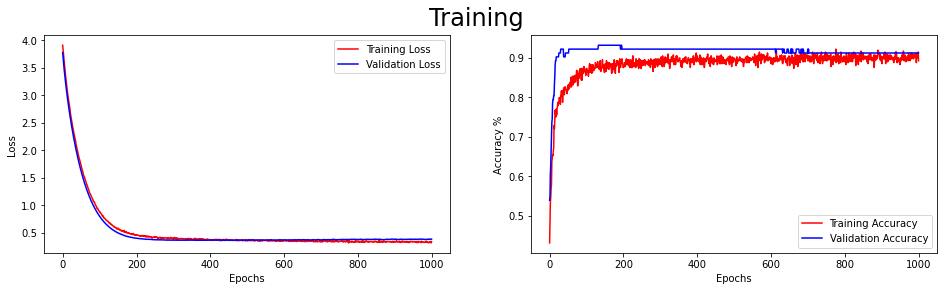

In [438]:
# Here we plot the training and validation loss and accuracy

fig, ax = plt.subplots(1,2,figsize = (16,4))
ax[0].plot(history.history['loss'],'r',label = 'Training Loss')
ax[0].plot(history.history['val_loss'],'b',label = 'Validation Loss')
ax[1].plot(history.history['accuracy'],'r',label = 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'],'b',label = 'Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs');
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %');
fig.suptitle('Training', fontsize = 24)

In [439]:
train_accuracy = round(NN_model.evaluate(X_train,y_train, verbose=0)[1], 3) #verbose=0

print(f'The training set accuracy for the model is {train_accuracy}')
      
#\\n The test set accuracy for the model is {test_accuracy}'

accuracies['Train']['Neural Network - regularised - 1000 epochs'] = history.history['val_accuracy'][-1]
accuracies['Dev']['Neural Network - regularised - 1000 epochs'] = history.history['accuracy'][-1]

The training set accuracy for the model is 0.906


In [440]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [441]:
accuracies_df = pd.DataFrame.from_dict(accuracies)
display(accuracies_df)

Train       Dev
Logistic regression (single predictor)              0.856098  0.810000
Logistic regression (all predictors)                0.809756  0.810000
Logistic regression (with Lasso)                    0.905000  0.920000
Logistic regression (with 2 principle components)   0.870732  0.840000
Logistic regression (with 15 principle components)  0.809756  0.810000
KNN (k=5)                                           0.873171  0.800000
KNN Optimised - (k=5)                               0.873171  0.800000
Decision Tree (depth 3)                             0.909756  0.890000
Random Forest Classifier                            1.000000  0.880000
Neural Network - regularised - 1000 epochs          0.911765  0.892157

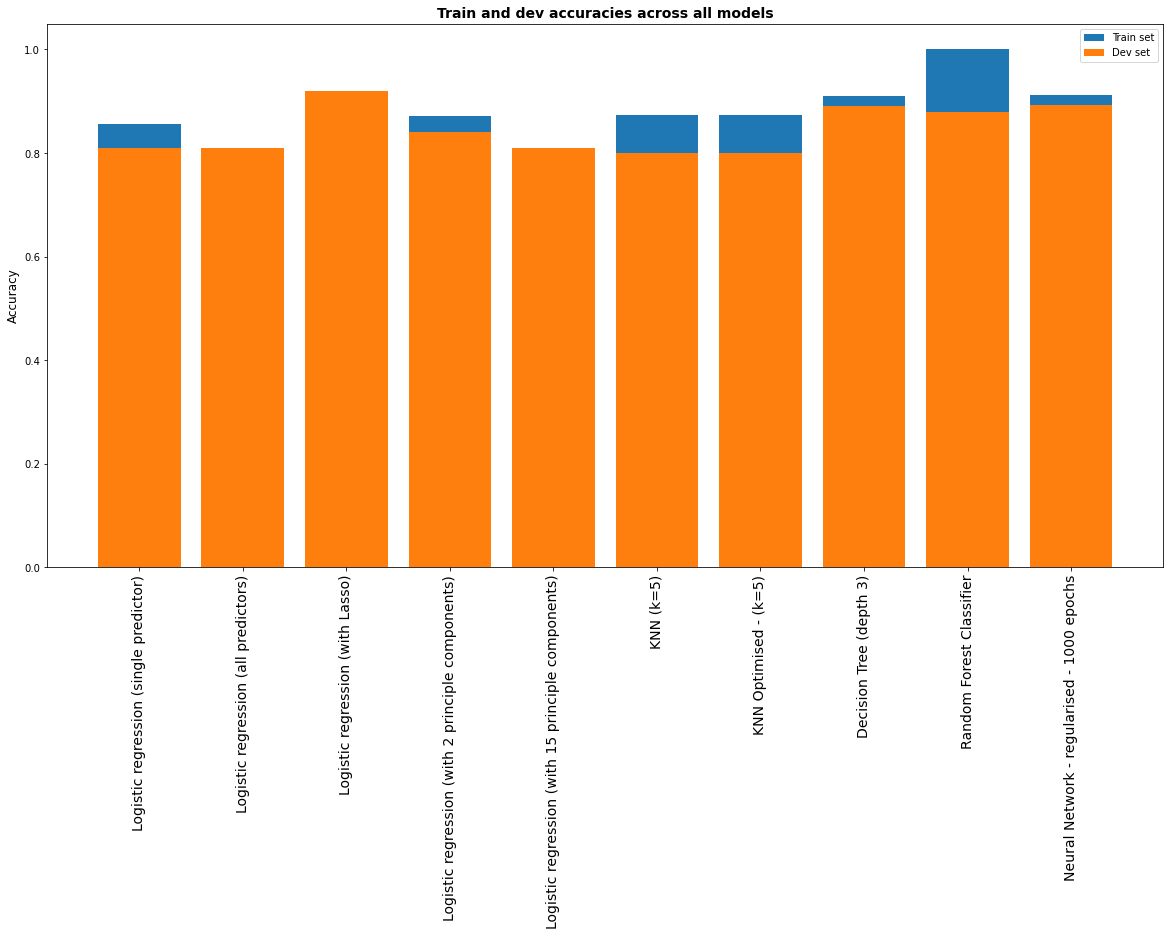

In [442]:
plt.figure(figsize=(20,10))
plt.bar(accuracies_df.index, accuracies_df['Train'], label='Train set')
plt.bar(accuracies_df.index, accuracies_df['Dev'], label='Dev set')
plt.title('Train and dev accuracies across all models', fontsize = 14, fontweight='bold')
plt.ylabel('Accuracy', fontsize = 12)
plt.xticks(rotation=90, fontsize = 14)
plt.legend()
plt.show()

In [443]:
logit_lasso_preds = logit_lasso.predict_proba(x_test)

test_data_dummy = test_data
test_data_dummy['preds'] = logit_lasso_preds[:,1]

x_test_dummy = x_test
x_test_dummy['preds'] = logit_lasso_preds[:,1]

#train_data_2016_dummy = train_data[(train_data.year == 2016)]
#logit_lasso_preds = logit_lasso.predict_proba(train_data_2016_dummy.drop('state'), axis=1)
#train_data_2016_dummy['preds'] = logit_lasso_preds[:,1]

# Transform election data 
states = set(test_data['state'])

years = ['2020']

preds_logit = {}
for year in years:
    
    result = {}
    for state in states:
        
        preds = x_test_dummy[(x_test_dummy.year == 2020) 
                              & (test_data.state == state)].preds.values[0]
        
        result[state] = {'preds':preds}
        
    preds_logit[year] = result
    

import branca.colormap as cm
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = preds_logit[year][state]
    
    #Set state colour
    if state_results['preds'] < 0.1: #change to dark red
        color = 'red' 
    elif state_results['preds'] < 0.4:
         color = '#fc9272' 
    elif state_results['preds'] < 0.6:
         color = '#fee5d9' 
    elif state_results['preds'] < 0.9: #Change to dark blue.
         color = '#6baed6'
    else:
        color = 'blue'
        
#> 0.2 & state_results['strike_rate'] 
    #else:
        #color = '#ff5b4f' #red
        
        # 0.4 & state_results['strike_rate']
        #> 0.6 & state_results['strike_rate'] 
    
    colormap = cm.LinearColormap(colors=['white', 'black'], index=[0,1.0],vmin=0,vmax=1)

    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 0.7,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,year='2020',function=True)
    
    return style

#plot the choropleth 
colormap = cm.LinearColormap(colors=['red', 'white','blue'], index=[0,0.5,1.0],vmin=0,vmax=1, caption="Lasso Logistic Regression: Confidence in prediction for each state")
m = folium.Map(location=[50.77500, -100],zoom_start=4) #Initialize map
choropleth =folium.GeoJson(data= states_gdf.to_json(),style_function=style_function)
m.add_child(choropleth)
m.add_child(colormap)

In [444]:
x_test = x_test.drop('preds', axis=1)

In [445]:
NN_model_preds = NN_model.predict_proba(X_test)

x_test_dummy = x_test.copy()
x_test_dummy['preds'] = NN_model_preds

#train_data_2016_dummy = train_data[(train_data.year == 2016)]
#logit_lasso_preds = logit_lasso.predict_proba(train_data_2016_dummy.drop('state'), axis=1)
#train_data_2016_dummy['preds'] = logit_lasso_preds[:,1]

# Transform election data 
states = set(test_data['state'])

years = ['2020']

preds_logit = {}
for year in years:
    
    result = {}
    for state in states:
        
        preds = x_test_dummy[(x_test_dummy.year == 2020) 
                              & (test_data.state == state)].preds.values[0]
        
        result[state] = {'preds':preds}
        
    preds_logit[year] = result
    

import branca.colormap as cm
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = preds_logit[year][state]
    
    #Set state colour
    if state_results['preds'] < 0.1: #change to dark red
        color = 'red' 
    elif state_results['preds'] < 0.4:
         color = '#fc9272' 
    elif state_results['preds'] < 0.6:
         color = '#fee5d9' 
    elif state_results['preds'] < 0.9: #Change to dark blue.
         color = '#6baed6'
    else:
        color = 'blue'
        
#> 0.2 & state_results['strike_rate'] 
    #else:
        #color = '#ff5b4f' #red
        
        # 0.4 & state_results['strike_rate']
        #> 0.6 & state_results['strike_rate'] 
    
    colormap = cm.LinearColormap(colors=['white', 'black'], index=[0,1.0],vmin=0,vmax=1)

    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 0.7,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,year='2020',function=True)
    
    return style

#plot the choropleth 
colormap = cm.LinearColormap(colors=['red', 'white','blue'], index=[0,0.5,1.0],vmin=0,vmax=1, caption="NN Model: Confidence in prediction for each state")
m = folium.Map(location=[50.77500, -100],zoom_start=4) #Initialize map
choropleth =folium.GeoJson(data= states_gdf.to_json(),style_function=style_function)
m.add_child(choropleth)
m.add_child(colormap)

In [446]:
model_rf_preds = model_rf.predict_proba(x_test)

test_data_dummy = test_data
test_data_dummy['preds'] = model_rf_preds[:,1]

x_test_dummy = x_test
x_test_dummy['preds'] = model_rf_preds[:,1]

#train_data_2016_dummy = train_data[(train_data.year == 2016)]
#logit_lasso_preds = logit_lasso.predict_proba(train_data_2016_dummy.drop('state'), axis=1)
#train_data_2016_dummy['preds'] = logit_lasso_preds[:,1]

# Transform election data 
states = set(test_data['state'])

years = ['2020']

preds_logit = {}
for year in years:
    
    result = {}
    for state in states:
        
        preds = x_test_dummy[(x_test_dummy.year == 2020) 
                              & (test_data.state == state)].preds.values[0]
        
        result[state] = {'preds':preds}
        
    preds_logit[year] = result
    

import branca.colormap as cm
def state_style(state,year,function=False):
    """
    Returns the style for a state in a given year
    """
    
    state_results = preds_logit[year][state]
    
    #Set state colour
    if state_results['preds'] < 0.1: #change to dark red
        color = 'red' 
    elif state_results['preds'] < 0.4:
         color = '#fc9272' 
    elif state_results['preds'] < 0.6:
         color = '#fee5d9' 
    elif state_results['preds'] < 0.9: #Change to dark blue.
         color = '#6baed6'
    else:
        color = 'blue'
        
#> 0.2 & state_results['strike_rate'] 
    #else:
        #color = '#ff5b4f' #red
        
        # 0.4 & state_results['strike_rate']
        #> 0.6 & state_results['strike_rate'] 
    
    colormap = cm.LinearColormap(colors=['white', 'black'], index=[0,1.0],vmin=0,vmax=1)

    
    #Set state style
    if function == False:
        # Format for style_dictionary
        state_style = {
            'opacity': 1,
            'color': color,
        } 
    else:
        # Format for style_fucntion
        state_style = {
             'fillOpacity': 0.7,
             'weight': 1,
             'fillColor': color,
             'color': '#000000'}    
  
    return state_style

def style_function(feature):
    """
    style_function used by the GeoJson folium function
    """

    state = feature['properties']['state_name']
    style = state_style(state,year='2020',function=True)
    
    return style

#plot the choropleth 
colormap = cm.LinearColormap(colors=['red', 'white','blue'], index=[0,0.5,1.0],vmin=0,vmax=1, caption="Random Forest: Confidence in prediction for each state")
m = folium.Map(location=[50.77500, -100],zoom_start=4) #Initialize map
choropleth =folium.GeoJson(data= states_gdf.to_json(),style_function=style_function)
m.add_child(choropleth)
m.add_child(colormap)

In [447]:
x_test = x_test.drop('preds', axis=1)

In [448]:
logit_lasso_score_test = round(logit_lasso.score(x_test, y_test), 3)
print('The accuracy on the test set for the second best model (Lasso Logistic Regression) is', logit_lasso_score_test)

The accuracy on the test set for the second best model (Lasso Logistic Regression) is 0.922


In [449]:
y_pred_test = model_rf.predict(x_test)
random_forest_test_score = accuracy_score(y_test, y_pred_test)
print("The accuracy on the test set for the  best model is  {:0.2f}".format(random_forest_test_score))

The accuracy on the test set for the  best model is  0.96
